In [5]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal
import gymnasium as gym
from collections import deque
from tqdm import tqdm


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
def preprocess(obs):
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    obs = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_NEAREST)
    return obs.astype(np.float32) / 255.0


In [8]:
frame_stack = deque(maxlen=4)

def get_state(obs):
    frame = preprocess(obs)
    frame_stack.append(frame)
    while len(frame_stack) < 4:
        frame_stack.append(frame)
    return np.stack(frame_stack, axis=0)  # (4, 84, 84)


In [ ]:
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        ) 

        self.fc = nn.Sequential(
            nn.Linear(3136, 512),  
            nn.ReLU()
        )
        
        # Separate output heads for mean and std
        self.mu = nn.Linear(512, 3)  # Mean for [steering, gas, brake]
        self.log_std = nn.Linear(512, 3)  # Separate std for each action
        self.value = nn.Linear(512, 1) # State value
    
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        mu = self.mu(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, min=-2, max=1.0)  # Prevent too large/small std
        std = torch.exp(log_std)
        value = self.value(x).squeeze(-1)
        return mu, std, value


In [10]:
def act(model, state):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    mu, std, value = model(state)
    dist = Normal(mu, std)
    action_raw = dist.sample()
    log_prob = dist.log_prob(action_raw).sum(dim=-1)
    
    # Store raw action for gradient computation
    action_raw_np = action_raw.squeeze(0).detach().cpu().numpy()
    
    # Scale actions for environment
    action = action_raw_np.copy()
    action[0] = np.tanh(action[0])  # steering in [-1, 1]
    action[1] = np.clip(action[1], 0.0, 1.0)  # gas
    action[2] = np.clip(action[2], 0.0, 1.0)  # brake

    return action, action_raw_np, log_prob.item(), value.item()

In [11]:
def compute_gae(rewards, values, dones, gamma=0.99, lam=0.95):
    advantages = []
    gae = 0
    values = values + [0]

    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * (1 - dones[step]) - values[step]
        gae = delta + gamma * lam * (1 - dones[step]) * gae
        advantages.insert(0, gae)

    returns = [adv + val for adv, val in zip(advantages, values[:-1])]
    return advantages, returns

In [12]:
def ppo_loss(model, states, actions, old_log_probs, returns, advantages, clip_epsilon=0.2, entropy_coef=0.02):
    mu, std, values = model(states)
    dist = Normal(mu, std)

    new_log_probs = dist.log_prob(actions).sum(dim=-1)
    ratio = torch.exp(new_log_probs - old_log_probs)

    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1.0 - clip_epsilon, 1.0 + clip_epsilon) * advantages
    policy_loss = -torch.min(surr1, surr2).mean()
    
    value_loss = torch.nn.functional.mse_loss(values, returns)
    
    entropy = dist.entropy().sum(dim=-1).mean()
    
    total_loss = policy_loss + 0.5 * value_loss - entropy_coef * entropy
    
    return total_loss, policy_loss.item(), value_loss.item(), entropy.item()


In [ ]:
env = gym.make('CarRacing-v3', render_mode=None, max_episode_steps=300)
model = ActorCritic().to(device)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
        nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.Conv2d):
        nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
num_updates = 500
steps_per_update = 2048
ppo_epochs = 10

episode_rewards = []
best_avg_reward = -float("inf")

obs, _ = env.reset()
frame_stack.clear()
state = get_state(obs)
episode_return = 0.0

for update in tqdm(range(num_updates)):
    states, actions_raw, log_probs = [], [], []
    rewards, values, dones = [], [], []

    # Collect trajectories
    with torch.no_grad():
        for step in range(steps_per_update):
            action, action_raw, log_prob, value = act(model, state)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            episode_return += reward

            states.append(state)
            actions_raw.append(action_raw)  # Store raw actions for gradient
            log_probs.append(log_prob)
            rewards.append(reward)
            values.append(value)
            dones.append(done)

            state = get_state(next_obs)

            if done:
                episode_rewards.append(episode_return)
                print(f"Episode finished with reward: {episode_return:.2f}")
                episode_return = 0.0

                obs, _ = env.reset()
                frame_stack.clear()
                state = get_state(obs)

    # Compute advantages and returns
    advantages, returns = compute_gae(rewards, values, dones)

    # Convert to tensors
    states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
    actions = torch.tensor(np.array(actions_raw), dtype=torch.float32).to(device)
    old_log_probs = torch.tensor(log_probs, dtype=torch.float32).to(device)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    advantages = torch.tensor(advantages, dtype=torch.float32).to(device)

    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # PPO update
    avg_loss, avg_policy_loss, avg_value_loss, avg_entropy = 0, 0, 0, 0
    
    for epoch in range(ppo_epochs):
        loss, p_loss, v_loss, ent = ppo_loss(
            model, states, actions, old_log_probs, returns, advantages
        )
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        avg_loss += loss.item()
        avg_policy_loss += p_loss
        avg_value_loss += v_loss
        avg_entropy += ent

    avg_loss /= ppo_epochs
    avg_policy_loss /= ppo_epochs
    avg_value_loss /= ppo_epochs
    avg_entropy /= ppo_epochs

    # Logging
    last_n = episode_rewards[-100:]
    avg_last_100 = sum(last_n) / len(last_n) if last_n else 0.0

    if avg_last_100 > best_avg_reward and len(last_n) >= 10:
        best_avg_reward = avg_last_100
        torch.save(model.state_dict(), "models/ppo_carracing_best.pt")
        print(f"New best model saved | Avg(100): {avg_last_100:.2f}")

    # Print current std values for debugging
    with torch.no_grad():
        sample_state = states[0:1]
        _, std, _ = model(sample_state)
        std_values = std.cpu().numpy()[0]
    
    print(
        f"Update {update+1}/{num_updates} | "
        f"Loss: {avg_loss:.4f} | P_Loss: {avg_policy_loss:.4f} | "
        f"V_Loss: {avg_value_loss:.4f} | Entropy: {avg_entropy:.4f} | "
        f"STD: [{std_values[0]:.3f}, {std_values[1]:.3f}, {std_values[2]:.3f}] | "
        f"Episodes: {len(episode_rewards)} | Avg(100): {avg_last_100:.2f}"
    )

env.close()

 48%|████▊     | 241/500 [2:15:56<2:32:14, 35.27s/it]

Update 241/500 | Loss: 34.1035 | P_Loss: 0.0009 | V_Loss: 68.4955 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1646 | Avg(100): 178.23
Episode finished with reward: 169.34
Episode finished with reward: 180.53
Episode finished with reward: 85.38
Episode finished with reward: 158.55
Episode finished with reward: 135.52
Episode finished with reward: 178.33


 48%|████▊     | 242/500 [2:16:25<2:22:55, 33.24s/it]

Update 242/500 | Loss: 23.7260 | P_Loss: -0.0007 | V_Loss: 47.7437 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1652 | Avg(100): 177.39
Episode finished with reward: 134.67
Episode finished with reward: 176.90
Episode finished with reward: 121.13
Episode finished with reward: 230.54
Episode finished with reward: 213.06
Episode finished with reward: 175.99
Episode finished with reward: 82.21


 49%|████▊     | 243/500 [2:16:54<2:17:19, 32.06s/it]

Update 243/500 | Loss: 21.4172 | P_Loss: 0.0025 | V_Loss: 43.1198 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1659 | Avg(100): 174.49
Episode finished with reward: 263.68
Episode finished with reward: 231.54
Episode finished with reward: 256.21
Episode finished with reward: 179.68
Episode finished with reward: 183.00
Episode finished with reward: 197.42
Episode finished with reward: 224.18


 49%|████▉     | 244/500 [2:17:19<2:07:32, 29.89s/it]

Update 244/500 | Loss: 26.0628 | P_Loss: 0.0032 | V_Loss: 52.4095 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1666 | Avg(100): 177.05
Episode finished with reward: 200.77
Episode finished with reward: 102.40
Episode finished with reward: 78.30
Episode finished with reward: 219.18
Episode finished with reward: 200.77
Episode finished with reward: 89.53
Episode finished with reward: 272.24


 49%|████▉     | 245/500 [2:17:45<2:02:11, 28.75s/it]

Update 245/500 | Loss: 39.0920 | P_Loss: 0.0023 | V_Loss: 78.4696 | Entropy: 7.2567 | STD: [2.718, 2.718, 2.718] | Episodes: 1673 | Avg(100): 175.52
Episode finished with reward: 175.78
Episode finished with reward: 147.36
Episode finished with reward: 167.32
Episode finished with reward: 157.30
Episode finished with reward: 221.63
Episode finished with reward: 37.16
Episode finished with reward: 240.90


 49%|████▉     | 246/500 [2:18:10<1:56:43, 27.57s/it]

Update 246/500 | Loss: 27.8792 | P_Loss: 0.0056 | V_Loss: 56.0375 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1680 | Avg(100): 172.73
Episode finished with reward: 181.07
Episode finished with reward: 172.85
Episode finished with reward: 136.67
Episode finished with reward: 110.41
Episode finished with reward: 137.20
Episode finished with reward: 110.07
Episode finished with reward: 198.84


 49%|████▉     | 247/500 [2:18:35<1:53:00, 26.80s/it]

Update 247/500 | Loss: 24.1603 | P_Loss: -0.0015 | V_Loss: 48.6140 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1687 | Avg(100): 170.36
Episode finished with reward: 194.14
Episode finished with reward: 171.39
Episode finished with reward: 197.76
Episode finished with reward: 182.12
Episode finished with reward: 224.30
Episode finished with reward: 154.13


 50%|████▉     | 248/500 [2:19:00<1:49:46, 26.13s/it]

Update 248/500 | Loss: 24.3772 | P_Loss: -0.0002 | V_Loss: 49.0452 | Entropy: 7.2565 | STD: [2.718, 2.718, 2.718] | Episodes: 1693 | Avg(100): 169.86
Episode finished with reward: 211.01
Episode finished with reward: 292.22
Episode finished with reward: 220.92
Episode finished with reward: 105.71
Episode finished with reward: 173.54
Episode finished with reward: 160.81
Episode finished with reward: 156.21


 50%|████▉     | 249/500 [2:19:24<1:47:39, 25.74s/it]

Update 249/500 | Loss: 20.4350 | P_Loss: 0.0056 | V_Loss: 41.1490 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1700 | Avg(100): 169.89
Episode finished with reward: 228.99
Episode finished with reward: 183.82
Episode finished with reward: 181.48
Episode finished with reward: 170.73
Episode finished with reward: 212.99
Episode finished with reward: 305.62
Episode finished with reward: 119.66


 50%|█████     | 250/500 [2:19:50<1:46:31, 25.57s/it]

Update 250/500 | Loss: 31.1630 | P_Loss: 0.0017 | V_Loss: 62.6129 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1707 | Avg(100): 171.94
Episode finished with reward: 261.23
Episode finished with reward: 287.15
Episode finished with reward: 317.37
Episode finished with reward: 244.19
Episode finished with reward: 237.61
Episode finished with reward: 253.02
Episode finished with reward: 164.14


 50%|█████     | 251/500 [2:20:15<1:45:41, 25.47s/it]

Update 251/500 | Loss: 36.3009 | P_Loss: 0.0068 | V_Loss: 72.8784 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1714 | Avg(100): 176.47
Episode finished with reward: 118.94
Episode finished with reward: 219.19
Episode finished with reward: 229.65
Episode finished with reward: 280.00
Episode finished with reward: 196.42
Episode finished with reward: 179.38
Episode finished with reward: 280.61


 50%|█████     | 252/500 [2:20:40<1:44:41, 25.33s/it]

Update 252/500 | Loss: 41.0518 | P_Loss: 0.0030 | V_Loss: 82.3879 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1721 | Avg(100): 179.86
Episode finished with reward: 178.49
Episode finished with reward: 268.70
Episode finished with reward: 309.16
Episode finished with reward: 196.97
Episode finished with reward: 285.02
Episode finished with reward: 288.49
Episode finished with reward: 288.03


 51%|█████     | 253/500 [2:21:05<1:44:17, 25.33s/it]

Update 253/500 | Loss: 48.0126 | P_Loss: 0.0092 | V_Loss: 96.2971 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1728 | Avg(100): 187.22
Episode finished with reward: 226.41
Episode finished with reward: 327.14
Episode finished with reward: 246.67
Episode finished with reward: 71.40
Episode finished with reward: 141.82
Episode finished with reward: 279.76


 51%|█████     | 254/500 [2:21:30<1:42:58, 25.12s/it]

Update 254/500 | Loss: 51.2225 | P_Loss: 0.0069 | V_Loss: 102.7214 | Entropy: 7.2567 | STD: [2.718, 2.718, 2.718] | Episodes: 1734 | Avg(100): 189.31
Episode finished with reward: 198.66
Episode finished with reward: 283.48
Episode finished with reward: 211.38
Episode finished with reward: 145.82
Episode finished with reward: 201.06
Episode finished with reward: 128.78
Episode finished with reward: 288.18


 51%|█████     | 255/500 [2:21:55<1:42:38, 25.14s/it]

Update 255/500 | Loss: 38.3682 | P_Loss: 0.0073 | V_Loss: 77.0119 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1741 | Avg(100): 193.70
Episode finished with reward: 239.37
Episode finished with reward: 22.68
Episode finished with reward: 305.50
Episode finished with reward: 382.59
Episode finished with reward: 292.03
Episode finished with reward: 285.11
Episode finished with reward: 205.67


 51%|█████     | 256/500 [2:22:20<1:42:23, 25.18s/it]

Update 256/500 | Loss: 51.5867 | P_Loss: 0.0241 | V_Loss: 103.4156 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1748 | Avg(100): 200.01
Episode finished with reward: 321.72
Episode finished with reward: 318.15
Episode finished with reward: 161.18
Episode finished with reward: 294.43
Episode finished with reward: 87.85
Episode finished with reward: -1.15
Episode finished with reward: 371.46


 51%|█████▏    | 257/500 [2:22:45<1:41:53, 25.16s/it]

Update 257/500 | Loss: 67.2402 | P_Loss: 0.0065 | V_Loss: 134.7576 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1755 | Avg(100): 205.64
Episode finished with reward: 152.37
Episode finished with reward: 296.09
Episode finished with reward: 166.23
Episode finished with reward: 259.81
Episode finished with reward: 120.00
Episode finished with reward: 68.98
Episode finished with reward: 139.55


 52%|█████▏    | 258/500 [2:23:11<1:41:59, 25.29s/it]

Update 258/500 | Loss: 41.1305 | P_Loss: 0.0033 | V_Loss: 82.5446 | Entropy: 7.2567 | STD: [2.718, 2.718, 2.718] | Episodes: 1762 | Avg(100): 203.14
Episode finished with reward: 148.14
Episode finished with reward: 340.91
Episode finished with reward: 131.54
Episode finished with reward: 139.55
Episode finished with reward: 247.97
Episode finished with reward: 2.93
Episode finished with reward: 307.75


 52%|█████▏    | 259/500 [2:23:37<1:42:52, 25.61s/it]

Update 259/500 | Loss: 52.2279 | P_Loss: 0.0230 | V_Loss: 104.7002 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1769 | Avg(100): 204.67
Episode finished with reward: 72.27
Episode finished with reward: 108.36
Episode finished with reward: 316.86
Episode finished with reward: 244.34
Episode finished with reward: 244.69
Episode finished with reward: 373.04


 52%|█████▏    | 260/500 [2:24:02<1:41:43, 25.43s/it]

Update 260/500 | Loss: 48.5702 | P_Loss: 0.0007 | V_Loss: 97.4292 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1775 | Avg(100): 207.21
Episode finished with reward: 135.35
Episode finished with reward: 248.75
Episode finished with reward: 188.46
Episode finished with reward: 290.75
Episode finished with reward: 271.42
Episode finished with reward: 311.64
Episode finished with reward: 241.29


 52%|█████▏    | 261/500 [2:24:27<1:40:16, 25.17s/it]

Update 261/500 | Loss: 45.9891 | P_Loss: 0.0002 | V_Loss: 92.2681 | Entropy: 7.2564 | STD: [2.718, 2.718, 2.718] | Episodes: 1782 | Avg(100): 212.31
Episode finished with reward: 108.69
Episode finished with reward: 288.03
Episode finished with reward: 166.26
Episode finished with reward: 329.59
Episode finished with reward: 277.69
Episode finished with reward: 322.94
Episode finished with reward: 226.49


 52%|█████▏    | 262/500 [2:24:51<1:39:03, 24.97s/it]

Update 262/500 | Loss: 40.9346 | P_Loss: 0.0187 | V_Loss: 82.1219 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1789 | Avg(100): 218.92
Episode finished with reward: 352.35
Episode finished with reward: 302.18
Episode finished with reward: 326.06
Episode finished with reward: 200.77
Episode finished with reward: 291.97
Episode finished with reward: 265.30
Episode finished with reward: 245.64


 53%|█████▎    | 263/500 [2:25:16<1:38:19, 24.89s/it]

Update 263/500 | Loss: 65.7684 | P_Loss: 0.0040 | V_Loss: 131.8191 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1796 | Avg(100): 223.93
Episode finished with reward: 132.25
Episode finished with reward: 222.49
Episode finished with reward: 306.84
Episode finished with reward: 224.36
Episode finished with reward: 300.19
Episode finished with reward: 310.62
Episode finished with reward: 140.65


 53%|█████▎    | 264/500 [2:25:41<1:38:01, 24.92s/it]

Update 264/500 | Loss: 46.3014 | P_Loss: -0.0024 | V_Loss: 92.8979 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1803 | Avg(100): 228.40
Episode finished with reward: 44.21
Episode finished with reward: 169.48
Episode finished with reward: 291.87
Episode finished with reward: 169.29
Episode finished with reward: 328.36
Episode finished with reward: 211.13
Episode finished with reward: 302.03


 53%|█████▎    | 265/500 [2:26:06<1:37:59, 25.02s/it]

Update 265/500 | Loss: 74.0474 | P_Loss: 0.0072 | V_Loss: 148.3707 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1810 | Avg(100): 226.82
Episode finished with reward: 254.58
Episode finished with reward: 267.69
Episode finished with reward: 99.69
Episode finished with reward: 37.38
Episode finished with reward: 317.97
Episode finished with reward: 325.81
Episode finished with reward: 31.53


 53%|█████▎    | 266/500 [2:26:31<1:36:45, 24.81s/it]

Update 266/500 | Loss: 52.6369 | P_Loss: 0.0163 | V_Loss: 105.5314 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1817 | Avg(100): 225.50
Episode finished with reward: 291.97
Episode finished with reward: 159.59
Episode finished with reward: 349.18
Episode finished with reward: 263.52
Episode finished with reward: 307.84
Episode finished with reward: 274.64
Episode finished with reward: 214.07


 53%|█████▎    | 267/500 [2:26:56<1:37:18, 25.06s/it]

Update 267/500 | Loss: 55.6409 | P_Loss: 0.0168 | V_Loss: 111.5384 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1824 | Avg(100): 227.18
Episode finished with reward: 243.29
Episode finished with reward: 336.44
Episode finished with reward: 275.66
Episode finished with reward: 28.14
Episode finished with reward: 309.29
Episode finished with reward: 326.88


 54%|█████▎    | 268/500 [2:27:21<1:36:33, 24.97s/it]

Update 268/500 | Loss: 60.7401 | P_Loss: 0.0231 | V_Loss: 121.7242 | Entropy: 7.2565 | STD: [2.718, 2.718, 2.718] | Episodes: 1830 | Avg(100): 226.26
Episode finished with reward: 264.29
Episode finished with reward: 270.75
Episode finished with reward: 143.91
Episode finished with reward: 200.47
Episode finished with reward: 311.18
Episode finished with reward: 116.67
Episode finished with reward: 228.56


 54%|█████▍    | 269/500 [2:27:46<1:35:43, 24.86s/it]

Update 269/500 | Loss: 64.4203 | P_Loss: 0.0311 | V_Loss: 129.0686 | Entropy: 7.2539 | STD: [2.718, 2.718, 2.718] | Episodes: 1837 | Avg(100): 227.28
Episode finished with reward: 166.49
Episode finished with reward: 292.09
Episode finished with reward: 215.90
Episode finished with reward: 215.95
Episode finished with reward: 290.42
Episode finished with reward: 285.79
Episode finished with reward: 255.71


 54%|█████▍    | 270/500 [2:28:11<1:35:26, 24.90s/it]

Update 270/500 | Loss: 52.7973 | P_Loss: 0.0056 | V_Loss: 105.8736 | Entropy: 7.2537 | STD: [2.718, 2.718, 2.718] | Episodes: 1844 | Avg(100): 231.19
Episode finished with reward: 286.90
Episode finished with reward: 207.01
Episode finished with reward: 168.44
Episode finished with reward: 285.44
Episode finished with reward: 303.33
Episode finished with reward: 270.00
Episode finished with reward: 318.66


 54%|█████▍    | 271/500 [2:28:35<1:34:40, 24.81s/it]

Update 271/500 | Loss: 44.0889 | P_Loss: 0.0130 | V_Loss: 88.4421 | Entropy: 7.2533 | STD: [2.718, 2.718, 2.718] | Episodes: 1851 | Avg(100): 229.92
Episode finished with reward: 241.52
Episode finished with reward: 377.94
Episode finished with reward: 220.75
Episode finished with reward: 225.59
Episode finished with reward: 127.23
Episode finished with reward: 146.47
Episode finished with reward: 224.90


 54%|█████▍    | 272/500 [2:29:00<1:34:14, 24.80s/it]

Update 272/500 | Loss: 49.5332 | P_Loss: -0.0005 | V_Loss: 99.3575 | Entropy: 7.2534 | STD: [2.718, 2.718, 2.718] | Episodes: 1858 | Avg(100): 231.90
Episode finished with reward: 306.73
Episode finished with reward: 191.24
Episode finished with reward: 224.68
Episode finished with reward: 170.72
Episode finished with reward: 356.03
Episode finished with reward: 250.94
Episode finished with reward: 288.52


 55%|█████▍    | 273/500 [2:29:25<1:33:48, 24.80s/it]

Update 273/500 | Loss: 48.5896 | P_Loss: 0.0010 | V_Loss: 97.4673 | Entropy: 7.2506 | STD: [2.718, 2.718, 2.718] | Episodes: 1865 | Avg(100): 237.70
Episode finished with reward: 227.58
Episode finished with reward: 241.52
Episode finished with reward: 76.01
Episode finished with reward: 298.86
Episode finished with reward: 154.40
Episode finished with reward: 160.94


 55%|█████▍    | 274/500 [2:29:50<1:33:51, 24.92s/it]

Update 274/500 | Loss: 43.6743 | P_Loss: -0.0009 | V_Loss: 87.6404 | Entropy: 7.2519 | STD: [2.718, 2.718, 2.718] | Episodes: 1871 | Avg(100): 240.50
Episode finished with reward: 304.51
Episode finished with reward: 300.99
Episode finished with reward: 399.18
Episode finished with reward: 312.02
Episode finished with reward: 284.20
Episode finished with reward: 309.29
Episode finished with reward: 271.42


 55%|█████▌    | 275/500 [2:30:15<1:33:57, 25.06s/it]

Update 275/500 | Loss: 50.8090 | P_Loss: 0.0034 | V_Loss: 101.9012 | Entropy: 7.2511 | STD: [2.718, 2.718, 2.718] | Episodes: 1878 | Avg(100): 244.80
Episode finished with reward: 298.62
Episode finished with reward: 142.96
Episode finished with reward: 241.68
Episode finished with reward: 278.97
Episode finished with reward: 131.29
Episode finished with reward: 211.61
Episode finished with reward: 247.78


 55%|█████▌    | 276/500 [2:30:40<1:32:49, 24.86s/it]

Update 276/500 | Loss: 44.9632 | P_Loss: 0.0060 | V_Loss: 90.2046 | Entropy: 7.2563 | STD: [2.718, 2.718, 2.718] | Episodes: 1885 | Avg(100): 243.55
Episode finished with reward: 272.16
Episode finished with reward: 315.45
Episode finished with reward: 298.57
Episode finished with reward: 206.53
Episode finished with reward: 278.55
Episode finished with reward: 293.89
Episode finished with reward: 276.12


 55%|█████▌    | 277/500 [2:31:05<1:32:19, 24.84s/it]

Update 277/500 | Loss: 53.3209 | P_Loss: 0.0018 | V_Loss: 106.9283 | Entropy: 7.2566 | STD: [2.718, 2.718, 2.718] | Episodes: 1892 | Avg(100): 241.59
Episode finished with reward: 316.02
Episode finished with reward: 310.14
Episode finished with reward: 229.82
Episode finished with reward: 250.37
Episode finished with reward: 297.46
Episode finished with reward: 303.33
Episode finished with reward: 250.76


 56%|█████▌    | 278/500 [2:31:29<1:31:50, 24.82s/it]

Update 278/500 | Loss: 49.0938 | P_Loss: 0.0293 | V_Loss: 98.4192 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1899 | Avg(100): 244.52
Episode finished with reward: 280.13
Episode finished with reward: 104.48
Episode finished with reward: 258.46
Episode finished with reward: 295.93
Episode finished with reward: 317.66
Episode finished with reward: 257.13
Episode finished with reward: 267.03


 56%|█████▌    | 279/500 [2:31:54<1:31:30, 24.84s/it]

Update 279/500 | Loss: 25.2140 | P_Loss: 0.0176 | V_Loss: 50.6831 | Entropy: 7.2566 | STD: [2.718, 2.718, 2.718] | Episodes: 1906 | Avg(100): 247.51
Episode finished with reward: 269.66
Episode finished with reward: 220.00
Episode finished with reward: 246.22
Episode finished with reward: 243.68
Episode finished with reward: 177.67
Episode finished with reward: 265.28


 56%|█████▌    | 280/500 [2:32:20<1:32:00, 25.09s/it]

Update 280/500 | Loss: 40.7882 | P_Loss: 0.0122 | V_Loss: 81.8423 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1912 | Avg(100): 246.40
Episode finished with reward: 230.00
Episode finished with reward: 232.59
Episode finished with reward: 203.87
Episode finished with reward: 279.03
Episode finished with reward: 157.05
Episode finished with reward: 276.12
Episode finished with reward: 310.35


 56%|█████▌    | 281/500 [2:32:45<1:31:21, 25.03s/it]

Update 281/500 | Loss: 42.9122 | P_Loss: 0.0035 | V_Loss: 86.1075 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1919 | Avg(100): 250.65
Episode finished with reward: 216.20
Episode finished with reward: 314.20
Episode finished with reward: 156.44
Episode finished with reward: 312.95
Episode finished with reward: 134.56
Episode finished with reward: 271.82
Episode finished with reward: 306.67


 56%|█████▋    | 282/500 [2:33:10<1:30:37, 24.94s/it]

Update 282/500 | Loss: 38.9053 | P_Loss: 0.0041 | V_Loss: 78.0927 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1926 | Avg(100): 247.89
Episode finished with reward: 274.20
Episode finished with reward: 164.72
Episode finished with reward: 188.88
Episode finished with reward: 303.33
Episode finished with reward: 267.30
Episode finished with reward: 236.67
Episode finished with reward: 338.22


 57%|█████▋    | 283/500 [2:33:34<1:30:01, 24.89s/it]

Update 283/500 | Loss: 49.9712 | P_Loss: 0.0037 | V_Loss: 100.2251 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1933 | Avg(100): 249.44
Episode finished with reward: 166.67
Episode finished with reward: 200.77
Episode finished with reward: 235.06
Episode finished with reward: 141.62
Episode finished with reward: 266.18
Episode finished with reward: 338.23
Episode finished with reward: 121.72


 57%|█████▋    | 284/500 [2:34:00<1:29:57, 24.99s/it]

Update 284/500 | Loss: 52.6924 | P_Loss: 0.0016 | V_Loss: 105.6719 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1940 | Avg(100): 248.83
Episode finished with reward: 221.66
Episode finished with reward: 297.76
Episode finished with reward: 147.78
Episode finished with reward: 211.57
Episode finished with reward: 300.99
Episode finished with reward: 256.98
Episode finished with reward: 232.50


 57%|█████▋    | 285/500 [2:34:25<1:29:44, 25.04s/it]

Update 285/500 | Loss: 42.5850 | P_Loss: 0.0048 | V_Loss: 85.4507 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1947 | Avg(100): 248.42
Episode finished with reward: 237.48
Episode finished with reward: 304.45
Episode finished with reward: 61.48
Episode finished with reward: 330.82
Episode finished with reward: 95.00
Episode finished with reward: 347.36


 57%|█████▋    | 286/500 [2:34:49<1:29:03, 24.97s/it]

Update 286/500 | Loss: 35.1800 | P_Loss: 0.0084 | V_Loss: 70.6335 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1953 | Avg(100): 244.21
Episode finished with reward: 262.36
Episode finished with reward: 355.77
Episode finished with reward: 339.34
Episode finished with reward: 309.93
Episode finished with reward: 296.92
Episode finished with reward: 222.46
Episode finished with reward: 225.32


 57%|█████▋    | 287/500 [2:35:14<1:28:04, 24.81s/it]

Update 287/500 | Loss: 43.4791 | P_Loss: 0.0209 | V_Loss: 87.2067 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1960 | Avg(100): 249.91
Episode finished with reward: 316.29
Episode finished with reward: 185.23
Episode finished with reward: 277.69
Episode finished with reward: 128.45
Episode finished with reward: 212.81
Episode finished with reward: 299.86
Episode finished with reward: 354.06


 58%|█████▊    | 288/500 [2:35:39<1:27:35, 24.79s/it]

Update 288/500 | Loss: 44.8829 | P_Loss: 0.0032 | V_Loss: 90.0496 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1967 | Avg(100): 250.05
Episode finished with reward: 353.51
Episode finished with reward: 272.63
Episode finished with reward: 331.20
Episode finished with reward: 252.83
Episode finished with reward: 233.49
Episode finished with reward: 315.45
Episode finished with reward: 319.44


 58%|█████▊    | 289/500 [2:36:04<1:27:16, 24.82s/it]

Update 289/500 | Loss: 68.2616 | P_Loss: 0.0064 | V_Loss: 136.8006 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1974 | Avg(100): 253.89
Episode finished with reward: 208.10
Episode finished with reward: 250.65
Episode finished with reward: 231.90
Episode finished with reward: 291.29
Episode finished with reward: 314.16
Episode finished with reward: 290.42
Episode finished with reward: 299.03


 58%|█████▊    | 290/500 [2:36:28<1:26:57, 24.85s/it]

Update 290/500 | Loss: 52.1792 | P_Loss: 0.0018 | V_Loss: 104.6450 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1981 | Avg(100): 254.14
Episode finished with reward: 175.78
Episode finished with reward: 203.90
Episode finished with reward: 212.21
Episode finished with reward: 224.79
Episode finished with reward: 214.76
Episode finished with reward: 296.86


 58%|█████▊    | 291/500 [2:36:54<1:26:54, 24.95s/it]

Update 291/500 | Loss: 40.1729 | P_Loss: 0.0021 | V_Loss: 80.6317 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1987 | Avg(100): 252.85
Episode finished with reward: 160.65
Episode finished with reward: 301.17
Episode finished with reward: 260.44
Episode finished with reward: 194.49
Episode finished with reward: 290.28
Episode finished with reward: 288.79
Episode finished with reward: 251.44


 58%|█████▊    | 292/500 [2:37:18<1:26:06, 24.84s/it]

Update 292/500 | Loss: 28.7376 | P_Loss: -0.0002 | V_Loss: 57.7659 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 1994 | Avg(100): 250.52
Episode finished with reward: 286.29
Episode finished with reward: 215.10
Episode finished with reward: 268.14
Episode finished with reward: 294.63
Episode finished with reward: 316.57
Episode finished with reward: 283.48
Episode finished with reward: 282.12


 59%|█████▊    | 293/500 [2:37:43<1:25:25, 24.76s/it]

Update 293/500 | Loss: 36.3111 | P_Loss: 0.0020 | V_Loss: 72.9084 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2001 | Avg(100): 252.82
Episode finished with reward: 289.00
Episode finished with reward: 246.98
Episode finished with reward: 238.14
Episode finished with reward: 111.84
Episode finished with reward: 292.58
Episode finished with reward: 262.21
Episode finished with reward: 316.41


 59%|█████▉    | 294/500 [2:38:08<1:25:21, 24.86s/it]

Update 294/500 | Loss: 41.4065 | P_Loss: 0.0014 | V_Loss: 83.1006 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2008 | Avg(100): 251.54
Episode finished with reward: 348.68
Episode finished with reward: 126.25
Episode finished with reward: 304.62
Episode finished with reward: 113.34
Episode finished with reward: 276.90
Episode finished with reward: 290.42
Episode finished with reward: 46.29


 59%|█████▉    | 295/500 [2:38:33<1:25:11, 24.93s/it]

Update 295/500 | Loss: 61.2090 | P_Loss: -0.0012 | V_Loss: 122.7107 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2015 | Avg(100): 250.61
Episode finished with reward: 157.73
Episode finished with reward: 129.17
Episode finished with reward: 247.78
Episode finished with reward: 392.54
Episode finished with reward: 239.84
Episode finished with reward: 112.36
Episode finished with reward: 296.73


 59%|█████▉    | 296/500 [2:38:58<1:25:02, 25.01s/it]

Update 296/500 | Loss: 37.4521 | P_Loss: 0.0036 | V_Loss: 75.1874 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2022 | Avg(100): 249.28
Episode finished with reward: 217.56
Episode finished with reward: 190.50
Episode finished with reward: 304.43
Episode finished with reward: 339.18
Episode finished with reward: 292.22
Episode finished with reward: 101.10


 59%|█████▉    | 297/500 [2:39:23<1:24:48, 25.07s/it]

Update 297/500 | Loss: 60.1883 | P_Loss: 0.0092 | V_Loss: 120.6483 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2028 | Avg(100): 249.08
Episode finished with reward: 313.86
Episode finished with reward: 252.76
Episode finished with reward: 312.02
Episode finished with reward: 284.47
Episode finished with reward: 279.03
Episode finished with reward: 233.94
Episode finished with reward: 258.75


 60%|█████▉    | 298/500 [2:39:48<1:24:17, 25.04s/it]

Update 298/500 | Loss: 28.1493 | P_Loss: 0.0059 | V_Loss: 56.5770 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2035 | Avg(100): 251.41
Episode finished with reward: 241.52
Episode finished with reward: 227.31
Episode finished with reward: 358.89
Episode finished with reward: 339.48
Episode finished with reward: 330.71
Episode finished with reward: 269.34
Episode finished with reward: 274.35


 60%|█████▉    | 299/500 [2:40:13<1:23:51, 25.03s/it]

Update 299/500 | Loss: 62.8970 | P_Loss: 0.0034 | V_Loss: 126.0775 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2042 | Avg(100): 255.60
Episode finished with reward: 290.26
Episode finished with reward: 293.02
Episode finished with reward: 195.59
Episode finished with reward: 266.30
Episode finished with reward: 206.76
Episode finished with reward: 207.34
Episode finished with reward: 247.78


 60%|██████    | 300/500 [2:40:38<1:22:49, 24.85s/it]

Update 300/500 | Loss: 62.9179 | P_Loss: -0.0002 | V_Loss: 126.1266 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2049 | Avg(100): 255.75
Episode finished with reward: 156.31
Episode finished with reward: 138.35
Episode finished with reward: 302.08
Episode finished with reward: 305.64
Episode finished with reward: 193.37
Episode finished with reward: 257.10
Episode finished with reward: 150.89


 60%|██████    | 301/500 [2:41:03<1:22:20, 24.82s/it]

Update 301/500 | Loss: 50.5078 | P_Loss: 0.0063 | V_Loss: 101.2932 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2056 | Avg(100): 252.87
Episode finished with reward: 296.09
Episode finished with reward: 262.93
Episode finished with reward: 106.52
Episode finished with reward: 287.88
Episode finished with reward: 195.00
Episode finished with reward: 220.00
Episode finished with reward: 219.24


 60%|██████    | 302/500 [2:41:27<1:21:52, 24.81s/it]

Update 302/500 | Loss: 54.5404 | P_Loss: 0.0079 | V_Loss: 109.3552 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2063 | Avg(100): 250.41
Episode finished with reward: 317.08
Episode finished with reward: 258.97
Episode finished with reward: 300.99
Episode finished with reward: 220.00
Episode finished with reward: 249.22
Episode finished with reward: 274.79


 61%|██████    | 303/500 [2:41:52<1:21:39, 24.87s/it]

Update 303/500 | Loss: 33.5907 | P_Loss: 0.0029 | V_Loss: 67.4659 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2069 | Avg(100): 250.41
Episode finished with reward: 209.04
Episode finished with reward: 163.42
Episode finished with reward: 323.17
Episode finished with reward: 332.26
Episode finished with reward: 86.54
Episode finished with reward: 287.07
Episode finished with reward: 347.86


 61%|██████    | 304/500 [2:42:17<1:20:58, 24.79s/it]

Update 304/500 | Loss: 51.8802 | P_Loss: 0.0019 | V_Loss: 104.0468 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2076 | Avg(100): 248.79
Episode finished with reward: 226.88
Episode finished with reward: 246.92
Episode finished with reward: 323.16
Episode finished with reward: 219.12
Episode finished with reward: 284.57
Episode finished with reward: 264.70
Episode finished with reward: 240.77


 61%|██████    | 305/500 [2:42:41<1:20:10, 24.67s/it]

Update 305/500 | Loss: 36.3784 | P_Loss: 0.0029 | V_Loss: 73.0412 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2083 | Avg(100): 248.78
Episode finished with reward: 158.81
Episode finished with reward: 218.28
Episode finished with reward: 245.32
Episode finished with reward: 283.13
Episode finished with reward: 284.19
Episode finished with reward: 242.08
Episode finished with reward: 257.58


 61%|██████    | 306/500 [2:43:06<1:20:03, 24.76s/it]

Update 306/500 | Loss: 51.7167 | P_Loss: 0.0054 | V_Loss: 103.7130 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2090 | Avg(100): 248.97
Episode finished with reward: 227.53
Episode finished with reward: 124.12
Episode finished with reward: 265.68
Episode finished with reward: 221.80
Episode finished with reward: 260.91
Episode finished with reward: 249.87
Episode finished with reward: 233.64


 61%|██████▏   | 307/500 [2:43:31<1:19:40, 24.77s/it]

Update 307/500 | Loss: 38.5969 | P_Loss: 0.0023 | V_Loss: 77.4795 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2097 | Avg(100): 246.86
Episode finished with reward: 102.81
Episode finished with reward: 313.07
Episode finished with reward: 285.97
Episode finished with reward: 253.74
Episode finished with reward: 229.94
Episode finished with reward: 238.46
Episode finished with reward: 268.61


 62%|██████▏   | 308/500 [2:43:56<1:19:28, 24.83s/it]

Update 308/500 | Loss: 42.0601 | P_Loss: 0.0109 | V_Loss: 84.3887 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2104 | Avg(100): 244.28
Episode finished with reward: 287.73
Episode finished with reward: 297.81
Episode finished with reward: 231.82
Episode finished with reward: 316.72
Episode finished with reward: 200.77
Episode finished with reward: 324.33


 62%|██████▏   | 309/500 [2:44:21<1:18:39, 24.71s/it]

Update 309/500 | Loss: 34.4968 | P_Loss: 0.0396 | V_Loss: 69.2047 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2110 | Avg(100): 246.29
Episode finished with reward: 244.02
Episode finished with reward: 217.31
Episode finished with reward: 273.14
Episode finished with reward: 254.67
Episode finished with reward: 1.97
Episode finished with reward: 249.22
Episode finished with reward: 255.71


 62%|██████▏   | 310/500 [2:44:45<1:17:56, 24.61s/it]

Update 310/500 | Loss: 38.2279 | P_Loss: 0.0028 | V_Loss: 76.7405 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2117 | Avg(100): 248.06
Episode finished with reward: 273.03
Episode finished with reward: 107.40
Episode finished with reward: 272.72
Episode finished with reward: 115.04
Episode finished with reward: 200.77
Episode finished with reward: 234.52
Episode finished with reward: 109.53


 62%|██████▏   | 311/500 [2:45:10<1:17:53, 24.73s/it]

Update 311/500 | Loss: 32.7975 | P_Loss: 0.0117 | V_Loss: 65.8618 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2124 | Avg(100): 244.22
Episode finished with reward: 294.43
Episode finished with reward: 285.25
Episode finished with reward: 302.10
Episode finished with reward: 262.13
Episode finished with reward: 322.06
Episode finished with reward: 162.03
Episode finished with reward: 245.86


 62%|██████▏   | 312/500 [2:45:35<1:17:42, 24.80s/it]

Update 312/500 | Loss: 33.2035 | P_Loss: 0.0002 | V_Loss: 66.6969 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2131 | Avg(100): 243.80
Episode finished with reward: 279.61
Episode finished with reward: 288.94
Episode finished with reward: 228.50
Episode finished with reward: 154.12
Episode finished with reward: 229.78
Episode finished with reward: 242.73
Episode finished with reward: 222.43


 63%|██████▎   | 313/500 [2:46:00<1:17:17, 24.80s/it]

Update 313/500 | Loss: 34.0697 | P_Loss: 0.0005 | V_Loss: 68.4287 | Entropy: 7.2566 | STD: [2.718, 2.718, 2.718] | Episodes: 2138 | Avg(100): 241.43
Episode finished with reward: 45.86
Episode finished with reward: 278.47
Episode finished with reward: 332.18
Episode finished with reward: 272.49
Episode finished with reward: 318.12
Episode finished with reward: 249.41
Episode finished with reward: 171.28


 63%|██████▎   | 314/500 [2:46:24<1:16:51, 24.80s/it]

Update 314/500 | Loss: 36.4038 | P_Loss: 0.0075 | V_Loss: 73.0829 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2145 | Avg(100): 238.18
Episode finished with reward: 309.48
Episode finished with reward: 288.49
Episode finished with reward: 290.63
Episode finished with reward: 267.62
Episode finished with reward: 153.39
Episode finished with reward: 241.90
Episode finished with reward: 338.42


 63%|██████▎   | 315/500 [2:46:49<1:16:28, 24.80s/it]

Update 315/500 | Loss: 36.5019 | P_Loss: 0.0072 | V_Loss: 73.2797 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2152 | Avg(100): 241.83
Episode finished with reward: 276.67
Episode finished with reward: 271.59
Episode finished with reward: 239.84
Episode finished with reward: 140.04
Episode finished with reward: 264.74
Episode finished with reward: 36.46


 63%|██████▎   | 316/500 [2:47:14<1:15:39, 24.67s/it]

Update 316/500 | Loss: 37.4026 | P_Loss: 0.0055 | V_Loss: 75.0844 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2158 | Avg(100): 239.46
Episode finished with reward: 67.47
Episode finished with reward: 126.46
Episode finished with reward: 258.14
Episode finished with reward: 314.09
Episode finished with reward: 244.92
Episode finished with reward: 55.41
Episode finished with reward: 278.77


 63%|██████▎   | 317/500 [2:47:39<1:15:32, 24.77s/it]

Update 317/500 | Loss: 24.9532 | P_Loss: 0.0023 | V_Loss: 50.1919 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2165 | Avg(100): 236.87
Episode finished with reward: 301.03
Episode finished with reward: 291.17
Episode finished with reward: 318.43
Episode finished with reward: 307.75
Episode finished with reward: 335.85
Episode finished with reward: 260.63
Episode finished with reward: 288.49


 64%|██████▎   | 318/500 [2:48:04<1:15:31, 24.90s/it]

Update 318/500 | Loss: 36.2776 | P_Loss: 0.0078 | V_Loss: 72.8300 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2172 | Avg(100): 240.49
Episode finished with reward: 346.38
Episode finished with reward: 372.34
Episode finished with reward: 231.59
Episode finished with reward: 318.28
Episode finished with reward: 263.71
Episode finished with reward: 341.53
Episode finished with reward: 286.13


 64%|██████▍   | 319/500 [2:48:28<1:14:52, 24.82s/it]

Update 319/500 | Loss: 48.0805 | P_Loss: 0.0070 | V_Loss: 96.4372 | Entropy: 7.2566 | STD: [2.718, 2.718, 2.718] | Episodes: 2179 | Avg(100): 243.59
Episode finished with reward: 168.61
Episode finished with reward: 279.21
Episode finished with reward: 318.92
Episode finished with reward: 362.31
Episode finished with reward: 273.03
Episode finished with reward: 293.08
Episode finished with reward: 152.43


 64%|██████▍   | 320/500 [2:48:53<1:14:23, 24.80s/it]

Update 320/500 | Loss: 55.0617 | P_Loss: 0.0075 | V_Loss: 110.3987 | Entropy: 7.2560 | STD: [2.718, 2.718, 2.718] | Episodes: 2186 | Avg(100): 245.75
Episode finished with reward: 310.35
Episode finished with reward: 263.29
Episode finished with reward: 274.64
Episode finished with reward: 173.01
Episode finished with reward: 295.26
Episode finished with reward: 303.33
Episode finished with reward: 247.07


 64%|██████▍   | 321/500 [2:49:18<1:13:58, 24.79s/it]

Update 321/500 | Loss: 31.5476 | P_Loss: 0.0109 | V_Loss: 63.3636 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2193 | Avg(100): 247.57
Episode finished with reward: 250.94
Episode finished with reward: 339.57
Episode finished with reward: 265.37
Episode finished with reward: 162.98
Episode finished with reward: 372.39
Episode finished with reward: 233.00


 64%|██████▍   | 322/500 [2:49:43<1:13:34, 24.80s/it]

Update 322/500 | Loss: 38.6149 | P_Loss: 0.0241 | V_Loss: 77.4719 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2199 | Avg(100): 249.99
Episode finished with reward: 262.83
Episode finished with reward: 251.35
Episode finished with reward: 350.07
Episode finished with reward: 299.19
Episode finished with reward: 110.41
Episode finished with reward: 354.62
Episode finished with reward: 218.50


 65%|██████▍   | 323/500 [2:50:08<1:13:28, 24.91s/it]

Update 323/500 | Loss: 28.8299 | P_Loss: -0.0005 | V_Loss: 57.9509 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2206 | Avg(100): 249.84
Episode finished with reward: 192.22
Episode finished with reward: 333.31
Episode finished with reward: 232.59
Episode finished with reward: 51.23
Episode finished with reward: 333.95
Episode finished with reward: 163.92
Episode finished with reward: 278.97


 65%|██████▍   | 324/500 [2:50:32<1:12:37, 24.76s/it]

Update 324/500 | Loss: 59.9790 | P_Loss: 0.0023 | V_Loss: 120.2436 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2213 | Avg(100): 247.62
Episode finished with reward: 344.13
Episode finished with reward: 295.84
Episode finished with reward: 209.20
Episode finished with reward: 260.54
Episode finished with reward: 332.55
Episode finished with reward: 133.76
Episode finished with reward: 310.07


 65%|██████▌   | 325/500 [2:50:57<1:12:15, 24.77s/it]

Update 325/500 | Loss: 72.0419 | P_Loss: -0.0000 | V_Loss: 144.3742 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2220 | Avg(100): 252.34
Episode finished with reward: 273.45
Episode finished with reward: 275.19
Episode finished with reward: 255.27
Episode finished with reward: 224.30
Episode finished with reward: 292.92
Episode finished with reward: 291.30
Episode finished with reward: 344.56


 65%|██████▌   | 326/500 [2:51:22<1:12:01, 24.83s/it]

Update 326/500 | Loss: 50.5341 | P_Loss: 0.0092 | V_Loss: 101.3400 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2227 | Avg(100): 256.49
Episode finished with reward: 352.14
Episode finished with reward: 309.04
Episode finished with reward: 247.44
Episode finished with reward: 127.89
Episode finished with reward: 269.00
Episode finished with reward: 214.51
Episode finished with reward: 290.13


 65%|██████▌   | 327/500 [2:51:47<1:11:34, 24.82s/it]

Update 327/500 | Loss: 31.8115 | P_Loss: 0.0005 | V_Loss: 63.9122 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2234 | Avg(100): 256.70
Episode finished with reward: 294.50
Episode finished with reward: 270.00
Episode finished with reward: 271.53
Episode finished with reward: 374.17
Episode finished with reward: 322.54
Episode finished with reward: 199.77


 66%|██████▌   | 328/500 [2:52:12<1:11:27, 24.93s/it]

Update 328/500 | Loss: 47.3387 | P_Loss: 0.0056 | V_Loss: 94.9566 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2240 | Avg(100): 262.29
Episode finished with reward: 386.67
Episode finished with reward: 283.17
Episode finished with reward: 337.59
Episode finished with reward: 258.03
Episode finished with reward: 128.45
Episode finished with reward: 221.52
Episode finished with reward: 82.28


 66%|██████▌   | 329/500 [2:52:37<1:10:57, 24.90s/it]

Update 329/500 | Loss: 40.7127 | P_Loss: 0.0057 | V_Loss: 81.7043 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2247 | Avg(100): 259.85
Episode finished with reward: 346.31
Episode finished with reward: 314.83
Episode finished with reward: 305.37
Episode finished with reward: 180.33
Episode finished with reward: 65.89
Episode finished with reward: 350.14
Episode finished with reward: 320.75


 66%|██████▌   | 330/500 [2:53:03<1:11:09, 25.11s/it]

Update 330/500 | Loss: 52.2923 | P_Loss: 0.0035 | V_Loss: 104.8679 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2254 | Avg(100): 260.29
Episode finished with reward: 227.35
Episode finished with reward: 153.05
Episode finished with reward: 231.48
Episode finished with reward: 99.03
Episode finished with reward: 295.88
Episode finished with reward: 303.33
Episode finished with reward: 132.16


 66%|██████▌   | 331/500 [2:53:30<1:12:29, 25.74s/it]

New best model saved | Avg(100): 263.38
Update 331/500 | Loss: 50.3283 | P_Loss: 0.0087 | V_Loss: 100.9295 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2261 | Avg(100): 263.38
Episode finished with reward: 119.85
Episode finished with reward: 261.10
Episode finished with reward: 345.00
Episode finished with reward: 271.37
Episode finished with reward: 327.14
Episode finished with reward: 206.42
Episode finished with reward: 297.81


 66%|██████▋   | 332/500 [2:53:55<1:11:44, 25.62s/it]

New best model saved | Avg(100): 263.63
Update 332/500 | Loss: 32.1268 | P_Loss: 0.0035 | V_Loss: 64.5368 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2268 | Avg(100): 263.63
Episode finished with reward: 141.82
Episode finished with reward: 345.45
Episode finished with reward: 389.61
Episode finished with reward: 218.43
Episode finished with reward: 244.13
Episode finished with reward: 291.19


 67%|██████▋   | 333/500 [2:54:20<1:10:17, 25.25s/it]

Update 333/500 | Loss: 44.2083 | P_Loss: 0.0023 | V_Loss: 88.7023 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2274 | Avg(100): 260.82
Episode finished with reward: 133.64
Episode finished with reward: 156.77
Episode finished with reward: 334.91
Episode finished with reward: 295.58
Episode finished with reward: 271.72
Episode finished with reward: 130.84
Episode finished with reward: 313.14


 67%|██████▋   | 334/500 [2:54:44<1:09:28, 25.11s/it]

Update 334/500 | Loss: 27.3353 | P_Loss: 0.0012 | V_Loss: 54.9584 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2281 | Avg(100): 258.29
Episode finished with reward: 225.03
Episode finished with reward: 54.54
Episode finished with reward: 202.92
Episode finished with reward: 142.66
Episode finished with reward: 322.35
Episode finished with reward: 153.15
Episode finished with reward: 227.14


 67%|██████▋   | 335/500 [2:55:09<1:08:28, 24.90s/it]

Update 335/500 | Loss: 40.8880 | P_Loss: 0.0048 | V_Loss: 82.0567 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2288 | Avg(100): 251.84
Episode finished with reward: 374.76
Episode finished with reward: 331.70
Episode finished with reward: 299.86
Episode finished with reward: 175.24
Episode finished with reward: 327.14
Episode finished with reward: 265.45
Episode finished with reward: 206.25


 67%|██████▋   | 336/500 [2:55:34<1:08:07, 24.93s/it]

Update 336/500 | Loss: 41.4188 | P_Loss: 0.0109 | V_Loss: 83.1060 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2295 | Avg(100): 252.80
Episode finished with reward: 247.03
Episode finished with reward: 261.51
Episode finished with reward: 370.00
Episode finished with reward: 71.35
Episode finished with reward: 372.30
Episode finished with reward: 286.60
Episode finished with reward: 305.77


 67%|██████▋   | 337/500 [2:55:58<1:07:35, 24.88s/it]

Update 337/500 | Loss: 59.2603 | P_Loss: 0.0028 | V_Loss: 118.8051 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2302 | Avg(100): 252.97
Episode finished with reward: 354.88
Episode finished with reward: 388.77
Episode finished with reward: 312.37
Episode finished with reward: 266.15
Episode finished with reward: 282.50
Episode finished with reward: 301.19
Episode finished with reward: 249.37


 68%|██████▊   | 338/500 [2:56:23<1:06:57, 24.80s/it]

Update 338/500 | Loss: 50.0873 | P_Loss: 0.0005 | V_Loss: 100.4639 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2309 | Avg(100): 257.11
Episode finished with reward: 310.00
Episode finished with reward: 201.37
Episode finished with reward: 313.86
Episode finished with reward: 110.94
Episode finished with reward: 231.01
Episode finished with reward: 300.94


 68%|██████▊   | 339/500 [2:56:48<1:06:32, 24.80s/it]

Update 339/500 | Loss: 58.6541 | P_Loss: 0.0117 | V_Loss: 117.5750 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2315 | Avg(100): 257.11
Episode finished with reward: 297.34
Episode finished with reward: 348.09
Episode finished with reward: 256.23
Episode finished with reward: 281.04
Episode finished with reward: 321.97
Episode finished with reward: 134.38
Episode finished with reward: 330.25


 68%|██████▊   | 340/500 [2:57:13<1:06:15, 24.85s/it]

Update 340/500 | Loss: 25.2176 | P_Loss: 0.0172 | V_Loss: 50.6910 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2322 | Avg(100): 258.86
Episode finished with reward: 128.09
Episode finished with reward: 355.71
Episode finished with reward: 363.26
Episode finished with reward: 285.60
Episode finished with reward: 376.47
Episode finished with reward: 150.21
Episode finished with reward: 303.33


 68%|██████▊   | 341/500 [2:57:37<1:05:40, 24.78s/it]

Update 341/500 | Loss: 45.1974 | P_Loss: 0.0121 | V_Loss: 90.6610 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2329 | Avg(100): 257.79
Episode finished with reward: 189.65
Episode finished with reward: 259.20
Episode finished with reward: 373.70
Episode finished with reward: 141.14
Episode finished with reward: 324.84
Episode finished with reward: 173.70
Episode finished with reward: 228.39


 68%|██████▊   | 342/500 [2:58:03<1:05:43, 24.96s/it]

Update 342/500 | Loss: 50.3945 | P_Loss: 0.0075 | V_Loss: 101.0642 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2336 | Avg(100): 257.56
Episode finished with reward: 326.88
Episode finished with reward: 283.73
Episode finished with reward: 126.25
Episode finished with reward: 163.10
Episode finished with reward: 241.52
Episode finished with reward: 249.22
Episode finished with reward: 311.46


 69%|██████▊   | 343/500 [2:58:28<1:05:38, 25.09s/it]

Update 343/500 | Loss: 66.4190 | P_Loss: 0.0001 | V_Loss: 133.1280 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2343 | Avg(100): 252.83
Episode finished with reward: 279.86
Episode finished with reward: 210.38
Episode finished with reward: 220.00
Episode finished with reward: 340.00
Episode finished with reward: 337.70
Episode finished with reward: 202.88
Episode finished with reward: 172.13


 69%|██████▉   | 344/500 [2:58:53<1:04:50, 24.94s/it]

Update 344/500 | Loss: 55.6635 | P_Loss: 0.0084 | V_Loss: 111.6006 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2350 | Avg(100): 253.89
Episode finished with reward: 368.55
Episode finished with reward: 314.95
Episode finished with reward: 322.74
Episode finished with reward: 122.32
Episode finished with reward: 225.64
Episode finished with reward: 302.28


 69%|██████▉   | 345/500 [2:59:17<1:04:10, 24.84s/it]

Update 345/500 | Loss: 42.5138 | P_Loss: 0.0026 | V_Loss: 85.3127 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2356 | Avg(100): 257.48
Episode finished with reward: 341.62
Episode finished with reward: 281.19
Episode finished with reward: 258.46
Episode finished with reward: 256.67
Episode finished with reward: 306.88
Episode finished with reward: 318.59
Episode finished with reward: 359.76


 69%|██████▉   | 346/500 [2:59:42<1:03:43, 24.83s/it]

New best model saved | Avg(100): 264.28
Update 346/500 | Loss: 35.8505 | P_Loss: 0.0053 | V_Loss: 71.9808 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2363 | Avg(100): 264.28
Episode finished with reward: 261.26
Episode finished with reward: 377.94
Episode finished with reward: 320.17
Episode finished with reward: 313.23
Episode finished with reward: 341.09
Episode finished with reward: 312.02
Episode finished with reward: 312.96


 69%|██████▉   | 347/500 [3:00:07<1:03:16, 24.81s/it]

New best model saved | Avg(100): 267.32
Update 347/500 | Loss: 38.8173 | P_Loss: 0.0028 | V_Loss: 77.9193 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2370 | Avg(100): 267.32
Episode finished with reward: 143.91
Episode finished with reward: 210.92
Episode finished with reward: 329.59
Episode finished with reward: 270.58
Episode finished with reward: 376.13
Episode finished with reward: 295.08
Episode finished with reward: 342.34


 70%|██████▉   | 348/500 [3:00:32<1:03:02, 24.88s/it]

New best model saved | Avg(100): 269.32
Update 348/500 | Loss: 48.5884 | P_Loss: 0.0051 | V_Loss: 97.4569 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2377 | Avg(100): 269.32
Episode finished with reward: 359.51
Episode finished with reward: 271.24
Episode finished with reward: 121.13
Episode finished with reward: 303.33
Episode finished with reward: 251.37
Episode finished with reward: 303.33
Episode finished with reward: 259.47


 70%|██████▉   | 349/500 [3:00:57<1:02:49, 24.96s/it]

New best model saved | Avg(100): 273.08
Update 349/500 | Loss: 65.3921 | P_Loss: 0.0114 | V_Loss: 131.0517 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2384 | Avg(100): 273.08
Episode finished with reward: 326.12
Episode finished with reward: 310.28
Episode finished with reward: 20.72
Episode finished with reward: 245.86
Episode finished with reward: 312.37
Episode finished with reward: 310.14
Episode finished with reward: 137.81


 70%|███████   | 350/500 [3:01:22<1:02:15, 24.91s/it]

Update 350/500 | Loss: 41.9974 | P_Loss: 0.0095 | V_Loss: 84.2662 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2391 | Avg(100): 271.19
Episode finished with reward: 284.49
Episode finished with reward: 341.32
Episode finished with reward: 301.08
Episode finished with reward: 240.00
Episode finished with reward: 282.69
Episode finished with reward: 126.35


 70%|███████   | 351/500 [3:01:47<1:01:47, 24.88s/it]

Update 351/500 | Loss: 41.4977 | P_Loss: 0.0131 | V_Loss: 83.2593 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2397 | Avg(100): 272.13
Episode finished with reward: 133.50
Episode finished with reward: 282.08
Episode finished with reward: 238.46
Episode finished with reward: 315.39
Episode finished with reward: 262.60
Episode finished with reward: 292.10
Episode finished with reward: 319.62


 70%|███████   | 352/500 [3:02:12<1:01:16, 24.84s/it]

Update 352/500 | Loss: 60.4006 | P_Loss: 0.0114 | V_Loss: 121.0686 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2404 | Avg(100): 269.07
Episode finished with reward: 274.20
Episode finished with reward: 373.77
Episode finished with reward: 321.35
Episode finished with reward: 126.25
Episode finished with reward: 274.83
Episode finished with reward: 240.83
Episode finished with reward: 282.93


 71%|███████   | 353/500 [3:02:36<1:00:41, 24.77s/it]

Update 353/500 | Loss: 41.4516 | P_Loss: 0.0068 | V_Loss: 83.1798 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2411 | Avg(100): 268.78
Episode finished with reward: 284.29
Episode finished with reward: 284.19
Episode finished with reward: 226.25
Episode finished with reward: 186.33
Episode finished with reward: 165.49
Episode finished with reward: 344.55
Episode finished with reward: 297.40


 71%|███████   | 354/500 [3:03:01<1:00:17, 24.78s/it]

Update 354/500 | Loss: 38.3533 | P_Loss: 0.0044 | V_Loss: 76.9882 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2418 | Avg(100): 268.08
Episode finished with reward: 237.86
Episode finished with reward: 309.93
Episode finished with reward: 272.49
Episode finished with reward: 353.80
Episode finished with reward: 316.29
Episode finished with reward: 257.20
Episode finished with reward: 269.27


 71%|███████   | 355/500 [3:03:25<59:35, 24.66s/it]  

Update 355/500 | Loss: 39.3177 | P_Loss: -0.0001 | V_Loss: 78.9259 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2425 | Avg(100): 269.10
Episode finished with reward: 285.44
Episode finished with reward: 227.86
Episode finished with reward: 334.66
Episode finished with reward: 210.96
Episode finished with reward: 270.31
Episode finished with reward: 273.03
Episode finished with reward: 129.48


 71%|███████   | 356/500 [3:03:50<59:29, 24.79s/it]

Update 356/500 | Loss: 31.2404 | P_Loss: 0.0002 | V_Loss: 62.7708 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2432 | Avg(100): 267.04
Episode finished with reward: 227.95
Episode finished with reward: 263.68
Episode finished with reward: 200.14
Episode finished with reward: 353.80
Episode finished with reward: 392.48
Episode finished with reward: 271.24


 71%|███████▏  | 357/500 [3:04:16<59:18, 24.88s/it]

Update 357/500 | Loss: 38.8874 | P_Loss: 0.0090 | V_Loss: 78.0471 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2438 | Avg(100): 269.34
Episode finished with reward: 315.45
Episode finished with reward: 293.13
Episode finished with reward: 312.28
Episode finished with reward: 237.97
Episode finished with reward: 308.61
Episode finished with reward: 259.72
Episode finished with reward: 366.30


 72%|███████▏  | 358/500 [3:04:41<58:58, 24.92s/it]

New best model saved | Avg(100): 274.46
Update 358/500 | Loss: 31.1176 | P_Loss: 0.0061 | V_Loss: 62.5133 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2445 | Avg(100): 274.46
Episode finished with reward: 127.14
Episode finished with reward: 199.89
Episode finished with reward: 265.77
Episode finished with reward: 257.13
Episode finished with reward: 149.05
Episode finished with reward: 308.65
Episode finished with reward: 222.56


 72%|███████▏  | 359/500 [3:05:06<58:35, 24.93s/it]

Update 359/500 | Loss: 45.2750 | P_Loss: -0.0005 | V_Loss: 90.8412 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2452 | Avg(100): 270.20
Episode finished with reward: 303.33
Episode finished with reward: 245.75
Episode finished with reward: 248.52
Episode finished with reward: 107.25
Episode finished with reward: 197.56
Episode finished with reward: 337.65
Episode finished with reward: 302.17


 72%|███████▏  | 360/500 [3:05:30<58:05, 24.89s/it]

Update 360/500 | Loss: 53.9763 | P_Loss: 0.0072 | V_Loss: 108.2284 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2459 | Avg(100): 269.08
Episode finished with reward: 363.38
Episode finished with reward: 87.65
Episode finished with reward: 269.66
Episode finished with reward: 329.86
Episode finished with reward: 285.60
Episode finished with reward: 265.03
Episode finished with reward: 123.85


 72%|███████▏  | 361/500 [3:05:55<57:44, 24.92s/it]

Update 361/500 | Loss: 35.2821 | P_Loss: 0.0062 | V_Loss: 70.8421 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2466 | Avg(100): 264.32
Episode finished with reward: 214.76
Episode finished with reward: 234.60
Episode finished with reward: 231.17
Episode finished with reward: 241.48
Episode finished with reward: 244.19
Episode finished with reward: 286.67
Episode finished with reward: 272.49


 72%|███████▏  | 362/500 [3:06:20<57:22, 24.95s/it]

Update 362/500 | Loss: 53.0380 | P_Loss: 0.0023 | V_Loss: 106.3617 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2473 | Avg(100): 261.93
Episode finished with reward: 293.74
Episode finished with reward: 264.92
Episode finished with reward: 186.56
Episode finished with reward: 314.09
Episode finished with reward: 257.36
Episode finished with reward: 115.33


 73%|███████▎  | 363/500 [3:06:45<56:53, 24.92s/it]

Update 363/500 | Loss: 40.9422 | P_Loss: 0.0024 | V_Loss: 82.1698 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2479 | Avg(100): 257.10
Episode finished with reward: 238.29
Episode finished with reward: 347.78
Episode finished with reward: 287.16
Episode finished with reward: 301.10
Episode finished with reward: 278.82
Episode finished with reward: 293.53
Episode finished with reward: 302.25


 73%|███████▎  | 364/500 [3:07:10<56:29, 24.92s/it]

Update 364/500 | Loss: 31.4567 | P_Loss: 0.0143 | V_Loss: 63.1749 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2486 | Avg(100): 258.84
Episode finished with reward: 362.59
Episode finished with reward: 245.86
Episode finished with reward: 126.13
Episode finished with reward: 286.98
Episode finished with reward: 286.73
Episode finished with reward: 210.00
Episode finished with reward: 299.86


 73%|███████▎  | 365/500 [3:07:35<55:58, 24.88s/it]

Update 365/500 | Loss: 43.9678 | P_Loss: 0.0051 | V_Loss: 88.2157 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2493 | Avg(100): 260.50
Episode finished with reward: 279.76
Episode finished with reward: 96.93
Episode finished with reward: 268.14
Episode finished with reward: 299.59
Episode finished with reward: 267.49
Episode finished with reward: 267.30
Episode finished with reward: 292.71


 73%|███████▎  | 366/500 [3:08:00<55:38, 24.91s/it]

Update 366/500 | Loss: 51.3778 | P_Loss: 0.0025 | V_Loss: 103.0409 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2500 | Avg(100): 262.18
Episode finished with reward: 183.86
Episode finished with reward: 222.63
Episode finished with reward: 243.89
Episode finished with reward: 264.74
Episode finished with reward: 197.41
Episode finished with reward: 283.17
Episode finished with reward: 311.00


 73%|███████▎  | 367/500 [3:08:25<55:32, 25.06s/it]

Update 367/500 | Loss: 60.2059 | P_Loss: 0.0023 | V_Loss: 120.6974 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2507 | Avg(100): 257.65
Episode finished with reward: 272.55
Episode finished with reward: 111.94
Episode finished with reward: 89.74
Episode finished with reward: 291.30
Episode finished with reward: 243.97
Episode finished with reward: 181.73


 74%|███████▎  | 368/500 [3:08:50<54:57, 24.98s/it]

Update 368/500 | Loss: 43.8848 | P_Loss: 0.0088 | V_Loss: 88.0424 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2513 | Avg(100): 254.63
Episode finished with reward: 300.88
Episode finished with reward: 305.91
Episode finished with reward: 292.03
Episode finished with reward: 318.48
Episode finished with reward: 173.28
Episode finished with reward: 210.68
Episode finished with reward: 210.63


 74%|███████▍  | 369/500 [3:09:14<54:09, 24.80s/it]

Update 369/500 | Loss: 49.6009 | P_Loss: 0.0041 | V_Loss: 99.4839 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2520 | Avg(100): 255.07
Episode finished with reward: 266.15
Episode finished with reward: 152.19
Episode finished with reward: 240.83
Episode finished with reward: 148.57
Episode finished with reward: 320.00
Episode finished with reward: 277.42
Episode finished with reward: 218.41


 74%|███████▍  | 370/500 [3:09:39<53:43, 24.80s/it]

Update 370/500 | Loss: 40.4603 | P_Loss: 0.0065 | V_Loss: 81.1979 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2527 | Avg(100): 251.48
Episode finished with reward: 263.71
Episode finished with reward: 66.77
Episode finished with reward: 283.99
Episode finished with reward: 90.69
Episode finished with reward: 166.23
Episode finished with reward: 278.92
Episode finished with reward: 282.30


 74%|███████▍  | 371/500 [3:10:04<53:11, 24.74s/it]

Update 371/500 | Loss: 36.9443 | P_Loss: 0.0042 | V_Loss: 74.1704 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2534 | Avg(100): 248.71
Episode finished with reward: 341.32
Episode finished with reward: 337.89
Episode finished with reward: 261.54
Episode finished with reward: 388.97
Episode finished with reward: 331.70
Episode finished with reward: 275.64
Episode finished with reward: 291.43


 74%|███████▍  | 372/500 [3:10:28<52:40, 24.70s/it]

Update 372/500 | Loss: 42.5701 | P_Loss: 0.0505 | V_Loss: 85.3295 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2541 | Avg(100): 249.61
Episode finished with reward: 192.93
Episode finished with reward: 300.77
Episode finished with reward: 340.97
Episode finished with reward: 328.21
Episode finished with reward: 224.36
Episode finished with reward: 266.55
Episode finished with reward: 150.51


 75%|███████▍  | 373/500 [3:10:53<52:12, 24.66s/it]

Update 373/500 | Loss: 41.2662 | P_Loss: 0.0089 | V_Loss: 82.8049 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2548 | Avg(100): 250.00
Episode finished with reward: 245.17
Episode finished with reward: 278.44
Episode finished with reward: 265.92
Episode finished with reward: 302.13
Episode finished with reward: 314.71
Episode finished with reward: 176.52


 75%|███████▍  | 374/500 [3:11:18<51:44, 24.64s/it]

Update 374/500 | Loss: 26.5052 | P_Loss: 0.0076 | V_Loss: 53.2856 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2554 | Avg(100): 250.96
Episode finished with reward: 238.29
Episode finished with reward: 305.74
Episode finished with reward: 323.16
Episode finished with reward: 314.16
Episode finished with reward: 323.36
Episode finished with reward: 283.38
Episode finished with reward: 191.37


 75%|███████▌  | 375/500 [3:11:42<51:18, 24.63s/it]

Update 375/500 | Loss: 43.0737 | P_Loss: 0.0210 | V_Loss: 86.3957 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2561 | Avg(100): 254.31
Episode finished with reward: 273.33
Episode finished with reward: 334.29
Episode finished with reward: 340.21
Episode finished with reward: 211.16
Episode finished with reward: 246.32
Episode finished with reward: 124.80
Episode finished with reward: 288.34


 75%|███████▌  | 376/500 [3:12:07<50:45, 24.56s/it]

Update 376/500 | Loss: 54.3047 | P_Loss: 0.0049 | V_Loss: 108.8898 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2568 | Avg(100): 255.27
Episode finished with reward: 299.90
Episode finished with reward: 327.62
Episode finished with reward: 293.43
Episode finished with reward: 300.36
Episode finished with reward: 224.30
Episode finished with reward: 344.56
Episode finished with reward: 132.87


 75%|███████▌  | 377/500 [3:12:31<50:29, 24.63s/it]

Update 377/500 | Loss: 34.4588 | P_Loss: 0.0064 | V_Loss: 69.1951 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2575 | Avg(100): 256.15
Episode finished with reward: 301.25
Episode finished with reward: 132.07
Episode finished with reward: 288.47
Episode finished with reward: 342.69
Episode finished with reward: 270.63
Episode finished with reward: 317.52
Episode finished with reward: 229.15


 76%|███████▌  | 378/500 [3:12:56<50:18, 24.74s/it]

Update 378/500 | Loss: 37.5129 | P_Loss: 0.0040 | V_Loss: 75.3081 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2582 | Avg(100): 257.50
Episode finished with reward: 219.11
Episode finished with reward: 297.53
Episode finished with reward: 212.62
Episode finished with reward: 254.75
Episode finished with reward: 335.13
Episode finished with reward: 327.64
Episode finished with reward: 92.30


 76%|███████▌  | 379/500 [3:13:21<49:47, 24.69s/it]

Update 379/500 | Loss: 49.2733 | P_Loss: 0.0043 | V_Loss: 98.8283 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2589 | Avg(100): 255.79
Episode finished with reward: 111.34
Episode finished with reward: 71.75
Episode finished with reward: 144.11
Episode finished with reward: 311.55
Episode finished with reward: 337.86
Episode finished with reward: 251.48


 76%|███████▌  | 380/500 [3:13:46<49:19, 24.66s/it]

Update 380/500 | Loss: 37.3141 | P_Loss: 0.0106 | V_Loss: 74.8972 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2595 | Avg(100): 253.47
Episode finished with reward: 292.34
Episode finished with reward: 356.62
Episode finished with reward: 86.98
Episode finished with reward: 202.93
Episode finished with reward: 142.16
Episode finished with reward: 36.30
Episode finished with reward: 258.08


 76%|███████▌  | 381/500 [3:14:10<48:55, 24.66s/it]

Update 381/500 | Loss: 72.4549 | P_Loss: 0.0029 | V_Loss: 145.1943 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2602 | Avg(100): 249.20
Episode finished with reward: 347.55
Episode finished with reward: 372.34
Episode finished with reward: 15.00
Episode finished with reward: 279.52
Episode finished with reward: 314.95
Episode finished with reward: 212.72
Episode finished with reward: 220.76


 76%|███████▋  | 382/500 [3:14:35<48:32, 24.68s/it]

Update 382/500 | Loss: 50.7679 | P_Loss: 0.0033 | V_Loss: 101.8194 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2609 | Avg(100): 249.99
Episode finished with reward: 146.47
Episode finished with reward: 171.41
Episode finished with reward: 284.64
Episode finished with reward: 358.70
Episode finished with reward: 287.16
Episode finished with reward: 352.35
Episode finished with reward: 343.24


 77%|███████▋  | 383/500 [3:15:00<48:11, 24.72s/it]

Update 383/500 | Loss: 32.1375 | P_Loss: 0.0020 | V_Loss: 64.5612 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2616 | Avg(100): 252.37
Episode finished with reward: 285.15
Episode finished with reward: 235.06
Episode finished with reward: 272.25
Episode finished with reward: 309.51
Episode finished with reward: 273.75
Episode finished with reward: 349.79
Episode finished with reward: 305.77


 77%|███████▋  | 384/500 [3:15:25<48:03, 24.86s/it]

Update 384/500 | Loss: 25.8181 | P_Loss: 0.0227 | V_Loss: 51.8810 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2623 | Avg(100): 256.96
Episode finished with reward: 34.28
Episode finished with reward: 372.30
Episode finished with reward: 275.26
Episode finished with reward: 291.21
Episode finished with reward: 280.00
Episode finished with reward: 379.25
Episode finished with reward: 285.29


 77%|███████▋  | 385/500 [3:15:50<47:43, 24.90s/it]

Update 385/500 | Loss: 87.2335 | P_Loss: 0.0245 | V_Loss: 174.7082 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2630 | Avg(100): 260.35
Episode finished with reward: 342.82
Episode finished with reward: 400.77
Episode finished with reward: 292.46
Episode finished with reward: 316.57
Episode finished with reward: 176.45
Episode finished with reward: 350.95
Episode finished with reward: 359.96


 77%|███████▋  | 386/500 [3:16:16<47:42, 25.11s/it]

Update 386/500 | Loss: 65.9859 | P_Loss: 0.0067 | V_Loss: 132.2486 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2637 | Avg(100): 265.16
Episode finished with reward: 299.03
Episode finished with reward: 292.78
Episode finished with reward: 287.15
Episode finished with reward: 52.73
Episode finished with reward: 321.35
Episode finished with reward: 279.76
Episode finished with reward: 241.74


 77%|███████▋  | 387/500 [3:16:40<46:58, 24.95s/it]

Update 387/500 | Loss: 55.7610 | P_Loss: 0.0146 | V_Loss: 111.7831 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2644 | Avg(100): 261.68
Episode finished with reward: 253.44
Episode finished with reward: 341.43
Episode finished with reward: 270.34
Episode finished with reward: 389.93
Episode finished with reward: 89.30
Episode finished with reward: 271.64
Episode finished with reward: 158.89


 78%|███████▊  | 388/500 [3:17:05<46:29, 24.91s/it]

Update 388/500 | Loss: 58.7338 | P_Loss: 0.0189 | V_Loss: 117.7201 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2651 | Avg(100): 261.84
Episode finished with reward: 254.72
Episode finished with reward: 291.55
Episode finished with reward: 248.93
Episode finished with reward: 266.88
Episode finished with reward: 46.08
Episode finished with reward: 345.00


 78%|███████▊  | 389/500 [3:17:30<46:00, 24.87s/it]

Update 389/500 | Loss: 56.4970 | P_Loss: 0.0081 | V_Loss: 113.2680 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2657 | Avg(100): 259.76
Episode finished with reward: 241.84
Episode finished with reward: 280.58
Episode finished with reward: 166.55
Episode finished with reward: 346.31
Episode finished with reward: 265.82
Episode finished with reward: 274.92
Episode finished with reward: 143.91


 78%|███████▊  | 390/500 [3:17:55<45:46, 24.97s/it]

Update 390/500 | Loss: 41.1258 | P_Loss: 0.0029 | V_Loss: 82.5361 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2664 | Avg(100): 256.36
Episode finished with reward: 266.77
Episode finished with reward: 287.57
Episode finished with reward: 257.29
Episode finished with reward: 334.29
Episode finished with reward: 307.84
Episode finished with reward: 300.22
Episode finished with reward: 312.86


 78%|███████▊  | 391/500 [3:18:20<45:28, 25.03s/it]

Update 391/500 | Loss: 33.7561 | P_Loss: 0.0023 | V_Loss: 67.7977 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2671 | Avg(100): 259.12
Episode finished with reward: 323.95
Episode finished with reward: 237.65
Episode finished with reward: 321.72
Episode finished with reward: 273.37
Episode finished with reward: 282.90
Episode finished with reward: 287.15
Episode finished with reward: 168.41


 78%|███████▊  | 392/500 [3:18:45<45:08, 25.08s/it]

Update 392/500 | Loss: 41.9376 | P_Loss: -0.0005 | V_Loss: 84.1665 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2678 | Avg(100): 260.83
Episode finished with reward: 170.72
Episode finished with reward: 150.56
Episode finished with reward: 364.56
Episode finished with reward: 174.38
Episode finished with reward: 322.11
Episode finished with reward: 349.06
Episode finished with reward: 188.95


 79%|███████▊  | 393/500 [3:19:10<44:35, 25.01s/it]

Update 393/500 | Loss: 41.9721 | P_Loss: 0.0070 | V_Loss: 84.2203 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2685 | Avg(100): 259.14
Episode finished with reward: 374.00
Episode finished with reward: 357.54
Episode finished with reward: 408.41
Episode finished with reward: 207.74
Episode finished with reward: 356.76
Episode finished with reward: 337.89
Episode finished with reward: 247.42


 79%|███████▉  | 394/500 [3:19:35<44:03, 24.94s/it]

Update 394/500 | Loss: 51.8413 | P_Loss: 0.0070 | V_Loss: 103.9590 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2692 | Avg(100): 268.67
Episode finished with reward: 327.86
Episode finished with reward: 139.74
Episode finished with reward: 97.91
Episode finished with reward: 121.20
Episode finished with reward: 256.67
Episode finished with reward: 374.18


 79%|███████▉  | 395/500 [3:20:00<43:51, 25.06s/it]

Update 395/500 | Loss: 41.6444 | P_Loss: 0.0005 | V_Loss: 83.5781 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2698 | Avg(100): 265.47
Episode finished with reward: 289.02
Episode finished with reward: 144.42
Episode finished with reward: 240.46
Episode finished with reward: 246.98
Episode finished with reward: 293.90
Episode finished with reward: 335.19
Episode finished with reward: 148.57


 79%|███████▉  | 396/500 [3:20:25<43:24, 25.05s/it]

Update 396/500 | Loss: 53.1274 | P_Loss: 0.0062 | V_Loss: 106.5327 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2705 | Avg(100): 268.72
Episode finished with reward: 337.65
Episode finished with reward: 225.56
Episode finished with reward: 367.73
Episode finished with reward: 241.90
Episode finished with reward: 272.25
Episode finished with reward: 133.64
Episode finished with reward: 325.70


 79%|███████▉  | 397/500 [3:20:50<42:57, 25.02s/it]

Update 397/500 | Loss: 49.5072 | P_Loss: 0.0014 | V_Loss: 99.3018 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2712 | Avg(100): 271.46
Episode finished with reward: 279.09
Episode finished with reward: 308.93
Episode finished with reward: 244.25
Episode finished with reward: 265.95
Episode finished with reward: 338.60
Episode finished with reward: 327.39
Episode finished with reward: 350.62


 80%|███████▉  | 398/500 [3:21:15<42:37, 25.08s/it]

Update 398/500 | Loss: 34.8568 | P_Loss: 0.0006 | V_Loss: 70.0025 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2719 | Avg(100): 271.26
Episode finished with reward: 247.07
Episode finished with reward: 137.76
Episode finished with reward: 380.91
Episode finished with reward: 170.00
Episode finished with reward: 304.39
Episode finished with reward: 246.53
Episode finished with reward: 308.51


 80%|███████▉  | 399/500 [3:21:41<42:21, 25.16s/it]

Update 399/500 | Loss: 35.3556 | P_Loss: 0.0084 | V_Loss: 70.9846 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2726 | Avg(100): 270.01
Episode finished with reward: 370.74
Episode finished with reward: 316.86
Episode finished with reward: 330.66
Episode finished with reward: 356.86
Episode finished with reward: 249.07
Episode finished with reward: 364.56
Episode finished with reward: 360.85


 80%|████████  | 400/500 [3:22:05<41:40, 25.01s/it]

Update 400/500 | Loss: 29.3965 | P_Loss: 0.0075 | V_Loss: 59.0683 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2733 | Avg(100): 270.79
Episode finished with reward: 124.93
Episode finished with reward: 140.29
Episode finished with reward: 380.71
Episode finished with reward: 305.62
Episode finished with reward: 354.62
Episode finished with reward: 139.06


 80%|████████  | 401/500 [3:22:30<41:14, 24.99s/it]

Update 401/500 | Loss: 40.0005 | P_Loss: 0.0056 | V_Loss: 80.2802 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2739 | Avg(100): 267.28
Episode finished with reward: 259.31
Episode finished with reward: 318.59
Episode finished with reward: 295.00
Episode finished with reward: 311.85
Episode finished with reward: 321.97
Episode finished with reward: 359.09
Episode finished with reward: 280.98


 80%|████████  | 402/500 [3:22:55<40:50, 25.00s/it]

Update 402/500 | Loss: 49.5683 | P_Loss: 0.0102 | V_Loss: 99.4066 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2746 | Avg(100): 270.97
Episode finished with reward: 318.28
Episode finished with reward: 367.81
Episode finished with reward: 118.79
Episode finished with reward: 323.15
Episode finished with reward: 345.86
Episode finished with reward: 96.15
Episode finished with reward: 133.76


 81%|████████  | 403/500 [3:23:21<40:31, 25.07s/it]

Update 403/500 | Loss: 47.1767 | P_Loss: 0.0044 | V_Loss: 94.6348 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2753 | Avg(100): 270.75
Episode finished with reward: 275.56
Episode finished with reward: 207.79
Episode finished with reward: 355.50
Episode finished with reward: 268.82
Episode finished with reward: 304.47
Episode finished with reward: 365.60
Episode finished with reward: 356.03


 81%|████████  | 404/500 [3:23:46<40:08, 25.09s/it]

New best model saved | Avg(100): 276.13
Update 404/500 | Loss: 52.8948 | P_Loss: 0.0069 | V_Loss: 106.0660 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2760 | Avg(100): 276.13
Episode finished with reward: 375.51
Episode finished with reward: 298.72
Episode finished with reward: 281.48
Episode finished with reward: 311.91
Episode finished with reward: 366.00
Episode finished with reward: 266.64
Episode finished with reward: 317.83


 81%|████████  | 405/500 [3:24:11<39:40, 25.06s/it]

New best model saved | Avg(100): 279.88
Update 405/500 | Loss: 62.7785 | P_Loss: 0.0057 | V_Loss: 125.8359 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2767 | Avg(100): 279.88
Episode finished with reward: 281.04
Episode finished with reward: 277.12
Episode finished with reward: 273.45
Episode finished with reward: 288.47
Episode finished with reward: 261.80
Episode finished with reward: 167.76


 81%|████████  | 406/500 [3:24:35<39:02, 24.92s/it]

Update 406/500 | Loss: 43.7832 | P_Loss: 0.0012 | V_Loss: 87.8542 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2773 | Avg(100): 277.21
Episode finished with reward: 224.61
Episode finished with reward: 261.97
Episode finished with reward: 342.09
Episode finished with reward: 208.23
Episode finished with reward: 213.59
Episode finished with reward: 284.88
Episode finished with reward: 290.26


 81%|████████▏ | 407/500 [3:25:00<38:34, 24.89s/it]

Update 407/500 | Loss: 52.7814 | P_Loss: 0.0015 | V_Loss: 105.8501 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2780 | Avg(100): 278.92
Episode finished with reward: 317.83
Episode finished with reward: 337.42
Episode finished with reward: 92.19
Episode finished with reward: 326.06
Episode finished with reward: 379.64
Episode finished with reward: 289.30
Episode finished with reward: 136.05


 82%|████████▏ | 408/500 [3:25:25<38:02, 24.81s/it]

Update 408/500 | Loss: 51.1330 | P_Loss: 0.0034 | V_Loss: 102.5495 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2787 | Avg(100): 276.40
Episode finished with reward: 325.87
Episode finished with reward: 325.47
Episode finished with reward: 293.02
Episode finished with reward: 131.65
Episode finished with reward: 261.02
Episode finished with reward: 328.65
Episode finished with reward: 178.82


 82%|████████▏ | 409/500 [3:25:50<37:36, 24.79s/it]

Update 409/500 | Loss: 48.0303 | P_Loss: 0.0158 | V_Loss: 96.3192 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2794 | Avg(100): 274.58
Episode finished with reward: 283.53
Episode finished with reward: 252.87
Episode finished with reward: 289.88
Episode finished with reward: 253.44
Episode finished with reward: 285.46
Episode finished with reward: 353.14
Episode finished with reward: 95.00


 82%|████████▏ | 410/500 [3:26:15<37:16, 24.85s/it]

Update 410/500 | Loss: 48.4388 | P_Loss: 0.0270 | V_Loss: 97.1140 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2801 | Avg(100): 277.48
Episode finished with reward: 262.93
Episode finished with reward: 261.67
Episode finished with reward: 241.43
Episode finished with reward: 274.08
Episode finished with reward: 239.74
Episode finished with reward: 171.37
Episode finished with reward: 268.61


 82%|████████▏ | 411/500 [3:26:40<37:00, 24.95s/it]

Update 411/500 | Loss: 44.7798 | P_Loss: 0.0052 | V_Loss: 89.8396 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2808 | Avg(100): 275.12
Episode finished with reward: 305.74
Episode finished with reward: 297.40
Episode finished with reward: 189.59
Episode finished with reward: 280.81
Episode finished with reward: 268.66
Episode finished with reward: 274.05


 82%|████████▏ | 412/500 [3:27:04<36:26, 24.84s/it]

Update 412/500 | Loss: 34.1990 | P_Loss: 0.0028 | V_Loss: 68.6827 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2814 | Avg(100): 275.67
Episode finished with reward: 284.94
Episode finished with reward: 115.16
Episode finished with reward: 296.80
Episode finished with reward: 223.42
Episode finished with reward: 301.13
Episode finished with reward: 204.66
Episode finished with reward: 260.00


 83%|████████▎ | 413/500 [3:27:29<35:49, 24.71s/it]

Update 413/500 | Loss: 46.6533 | P_Loss: 0.0011 | V_Loss: 93.5947 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2821 | Avg(100): 273.41
Episode finished with reward: 312.31
Episode finished with reward: 298.41
Episode finished with reward: 134.91
Episode finished with reward: 289.15
Episode finished with reward: 246.60
Episode finished with reward: 322.27
Episode finished with reward: 273.57


 83%|████████▎ | 414/500 [3:27:53<35:21, 24.67s/it]

Update 414/500 | Loss: 35.3340 | P_Loss: 0.0069 | V_Loss: 70.9446 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2828 | Avg(100): 271.21
Episode finished with reward: 196.54
Episode finished with reward: 163.64
Episode finished with reward: 218.39
Episode finished with reward: 260.54
Episode finished with reward: 157.02
Episode finished with reward: 312.86
Episode finished with reward: 326.36


 83%|████████▎ | 415/500 [3:28:18<35:05, 24.77s/it]

Update 415/500 | Loss: 47.6332 | P_Loss: 0.0049 | V_Loss: 95.5468 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2835 | Avg(100): 268.29
Episode finished with reward: 326.62
Episode finished with reward: 338.42
Episode finished with reward: 312.11
Episode finished with reward: 309.22
Episode finished with reward: 175.13
Episode finished with reward: 64.16
Episode finished with reward: 43.09


 83%|████████▎ | 416/500 [3:28:43<34:47, 24.85s/it]

Update 416/500 | Loss: 46.7735 | P_Loss: 0.0014 | V_Loss: 93.8346 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2842 | Avg(100): 263.45
Episode finished with reward: 311.06
Episode finished with reward: 326.16
Episode finished with reward: 280.34
Episode finished with reward: 336.41
Episode finished with reward: 148.69
Episode finished with reward: 301.08
Episode finished with reward: 313.64


 83%|████████▎ | 417/500 [3:29:09<34:35, 25.00s/it]

Update 417/500 | Loss: 48.6783 | P_Loss: 0.0150 | V_Loss: 97.6168 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2849 | Avg(100): 262.83
Episode finished with reward: 283.79
Episode finished with reward: 190.54
Episode finished with reward: 250.90
Episode finished with reward: 295.26
Episode finished with reward: 174.46
Episode finished with reward: 140.45


 84%|████████▎ | 418/500 [3:29:34<34:14, 25.05s/it]

Update 418/500 | Loss: 33.9104 | P_Loss: 0.0025 | V_Loss: 68.1061 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2855 | Avg(100): 262.36
Episode finished with reward: 192.97
Episode finished with reward: 280.00
Episode finished with reward: 355.71
Episode finished with reward: 234.26
Episode finished with reward: 246.67
Episode finished with reward: 287.65
Episode finished with reward: 155.31


 84%|████████▍ | 419/500 [3:29:58<33:38, 24.92s/it]

Update 419/500 | Loss: 45.3441 | P_Loss: 0.0054 | V_Loss: 90.9677 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2862 | Avg(100): 256.64
Episode finished with reward: 143.61
Episode finished with reward: 268.36
Episode finished with reward: 285.25
Episode finished with reward: 333.31
Episode finished with reward: 182.36
Episode finished with reward: 257.67
Episode finished with reward: 277.69


 84%|████████▍ | 420/500 [3:30:23<33:15, 24.94s/it]

Update 420/500 | Loss: 35.2779 | P_Loss: 0.0053 | V_Loss: 70.8355 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2869 | Avg(100): 253.11
Episode finished with reward: 335.31
Episode finished with reward: 279.45
Episode finished with reward: 299.97
Episode finished with reward: 307.50
Episode finished with reward: 285.25
Episode finished with reward: 123.33
Episode finished with reward: 260.00


 84%|████████▍ | 421/500 [3:30:49<33:00, 25.07s/it]

Update 421/500 | Loss: 29.7922 | P_Loss: 0.0050 | V_Loss: 59.8647 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2876 | Avg(100): 253.81
Episode finished with reward: 116.43
Episode finished with reward: 170.73
Episode finished with reward: 233.33
Episode finished with reward: 255.71
Episode finished with reward: 12.29
Episode finished with reward: 301.15
Episode finished with reward: 139.06


 84%|████████▍ | 422/500 [3:31:14<32:35, 25.08s/it]

Update 422/500 | Loss: 52.4662 | P_Loss: 0.0025 | V_Loss: 105.2177 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2883 | Avg(100): 248.66
Episode finished with reward: 238.07
Episode finished with reward: 155.61
Episode finished with reward: 218.28
Episode finished with reward: 172.99
Episode finished with reward: 105.14
Episode finished with reward: 314.32
Episode finished with reward: 309.84


 85%|████████▍ | 423/500 [3:31:39<32:02, 24.97s/it]

Update 423/500 | Loss: 50.5549 | P_Loss: 0.0073 | V_Loss: 101.3855 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2890 | Avg(100): 243.04
Episode finished with reward: 11.41
Episode finished with reward: 325.56
Episode finished with reward: 159.19
Episode finished with reward: 267.81
Episode finished with reward: 345.00
Episode finished with reward: 314.09
Episode finished with reward: 336.52


 85%|████████▍ | 424/500 [3:32:04<31:37, 24.97s/it]

Update 424/500 | Loss: 46.5146 | P_Loss: 0.0003 | V_Loss: 93.3188 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2897 | Avg(100): 243.37
Episode finished with reward: 312.28
Episode finished with reward: 299.79
Episode finished with reward: 249.07
Episode finished with reward: 314.83
Episode finished with reward: 305.64
Episode finished with reward: 341.02


 85%|████████▌ | 425/500 [3:32:28<31:04, 24.86s/it]

Update 425/500 | Loss: 32.8226 | P_Loss: 0.0084 | V_Loss: 65.9187 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2903 | Avg(100): 246.48
Episode finished with reward: 320.82
Episode finished with reward: 139.49
Episode finished with reward: 202.26
Episode finished with reward: 362.98
Episode finished with reward: 316.86
Episode finished with reward: 272.25
Episode finished with reward: 71.85


 85%|████████▌ | 426/500 [3:32:53<30:42, 24.90s/it]

Update 426/500 | Loss: 40.4679 | P_Loss: 0.0255 | V_Loss: 81.1751 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2910 | Avg(100): 245.37
Episode finished with reward: 288.64
Episode finished with reward: 240.83
Episode finished with reward: 166.36
Episode finished with reward: 292.26
Episode finished with reward: 193.83
Episode finished with reward: 135.02
Episode finished with reward: 257.77


 85%|████████▌ | 427/500 [3:33:18<30:15, 24.87s/it]

Update 427/500 | Loss: 53.4944 | P_Loss: 0.0343 | V_Loss: 107.2104 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2917 | Avg(100): 244.01
Episode finished with reward: 236.44
Episode finished with reward: 244.31
Episode finished with reward: 213.14
Episode finished with reward: 198.23
Episode finished with reward: 184.79
Episode finished with reward: 236.67
Episode finished with reward: 79.76


 86%|████████▌ | 428/500 [3:33:43<29:53, 24.91s/it]

Update 428/500 | Loss: 59.0818 | P_Loss: 0.0355 | V_Loss: 118.3830 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2924 | Avg(100): 240.60
Episode finished with reward: 204.04
Episode finished with reward: 195.69
Episode finished with reward: 195.19
Episode finished with reward: 141.82
Episode finished with reward: 141.05
Episode finished with reward: 184.29
Episode finished with reward: 207.94


 86%|████████▌ | 429/500 [3:34:08<29:29, 24.93s/it]

Update 429/500 | Loss: 56.3938 | P_Loss: 0.0108 | V_Loss: 113.0562 | Entropy: 7.2534 | STD: [2.718, 2.718, 2.718] | Episodes: 2931 | Avg(100): 236.20
Episode finished with reward: 99.03
Episode finished with reward: 124.36
Episode finished with reward: 203.44
Episode finished with reward: 111.30
Episode finished with reward: 100.00
Episode finished with reward: 130.84


 86%|████████▌ | 430/500 [3:34:33<29:02, 24.89s/it]

Update 430/500 | Loss: 17.8235 | P_Loss: 0.0006 | V_Loss: 35.9360 | Entropy: 7.2541 | STD: [2.718, 2.718, 2.718] | Episodes: 2937 | Avg(100): 226.67
Episode finished with reward: 82.90
Episode finished with reward: 111.48
Episode finished with reward: 271.82
Episode finished with reward: 303.33
Episode finished with reward: 207.95
Episode finished with reward: 214.15
Episode finished with reward: 87.09


 86%|████████▌ | 431/500 [3:34:58<28:35, 24.86s/it]

Update 431/500 | Loss: 24.7761 | P_Loss: 0.0012 | V_Loss: 49.8396 | Entropy: 7.2473 | STD: [2.718, 2.718, 2.718] | Episodes: 2944 | Avg(100): 224.05
Episode finished with reward: 130.84
Episode finished with reward: 36.04
Episode finished with reward: 170.00
Episode finished with reward: 200.19
Episode finished with reward: 272.16
Episode finished with reward: 137.27
Episode finished with reward: 261.51


 86%|████████▋ | 432/500 [3:35:22<28:06, 24.80s/it]

Update 432/500 | Loss: 34.4619 | P_Loss: -0.0007 | V_Loss: 69.2154 | Entropy: 7.2532 | STD: [2.718, 2.718, 2.718] | Episodes: 2951 | Avg(100): 217.58
Episode finished with reward: 278.88
Episode finished with reward: 161.34
Episode finished with reward: 177.00
Episode finished with reward: 237.33
Episode finished with reward: 256.23
Episode finished with reward: 139.93
Episode finished with reward: 156.05


 87%|████████▋ | 433/500 [3:35:47<27:47, 24.89s/it]

Update 433/500 | Loss: 31.8918 | P_Loss: 0.0046 | V_Loss: 64.0646 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2958 | Avg(100): 214.75
Episode finished with reward: 120.64
Episode finished with reward: 206.25
Episode finished with reward: 153.23
Episode finished with reward: 229.12
Episode finished with reward: 221.38
Episode finished with reward: 234.81
Episode finished with reward: 211.04


 87%|████████▋ | 434/500 [3:36:13<27:29, 24.99s/it]

Update 434/500 | Loss: 42.9943 | P_Loss: 0.0021 | V_Loss: 86.2748 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2965 | Avg(100): 212.30
Episode finished with reward: 203.72
Episode finished with reward: 220.00
Episode finished with reward: 211.27
Episode finished with reward: 125.80
Episode finished with reward: 214.97
Episode finished with reward: 296.60
Episode finished with reward: 211.50


 87%|████████▋ | 435/500 [3:36:37<27:00, 24.93s/it]

Update 435/500 | Loss: 30.8382 | P_Loss: 0.0064 | V_Loss: 61.9539 | Entropy: 7.2567 | STD: [2.718, 2.718, 2.718] | Episodes: 2972 | Avg(100): 207.49
Episode finished with reward: 138.87
Episode finished with reward: 227.63
Episode finished with reward: 290.00
Episode finished with reward: 232.46
Episode finished with reward: 221.85
Episode finished with reward: 236.67


 87%|████████▋ | 436/500 [3:37:02<26:32, 24.89s/it]

Update 436/500 | Loss: 21.8374 | P_Loss: 0.0044 | V_Loss: 43.9560 | Entropy: 7.2497 | STD: [2.718, 2.718, 2.718] | Episodes: 2978 | Avg(100): 208.33
Episode finished with reward: 226.67
Episode finished with reward: 137.72
Episode finished with reward: 156.85
Episode finished with reward: 257.88
Episode finished with reward: 210.85
Episode finished with reward: 178.61
Episode finished with reward: 251.88


 87%|████████▋ | 437/500 [3:37:27<26:03, 24.82s/it]

Update 437/500 | Loss: 26.8324 | P_Loss: 0.0095 | V_Loss: 53.9360 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2985 | Avg(100): 209.18
Episode finished with reward: 126.49
Episode finished with reward: 237.61
Episode finished with reward: 304.59
Episode finished with reward: 191.21
Episode finished with reward: 253.78
Episode finished with reward: 197.59
Episode finished with reward: 253.09


 88%|████████▊ | 438/500 [3:37:52<25:47, 24.96s/it]

Update 438/500 | Loss: 24.7480 | P_Loss: 0.0038 | V_Loss: 49.7786 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2992 | Avg(100): 210.25
Episode finished with reward: 111.84
Episode finished with reward: 128.49
Episode finished with reward: 286.50
Episode finished with reward: 261.67
Episode finished with reward: 263.04
Episode finished with reward: 239.78
Episode finished with reward: 257.63


 88%|████████▊ | 439/500 [3:38:17<25:20, 24.92s/it]

Update 439/500 | Loss: 26.2341 | P_Loss: 0.0158 | V_Loss: 52.7270 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 2999 | Avg(100): 205.39
Episode finished with reward: 37.09
Episode finished with reward: 213.15
Episode finished with reward: 113.84
Episode finished with reward: 250.53
Episode finished with reward: 320.36
Episode finished with reward: 177.55
Episode finished with reward: 231.82


 88%|████████▊ | 440/500 [3:38:42<25:00, 25.01s/it]

Update 440/500 | Loss: 35.0297 | P_Loss: 0.0041 | V_Loss: 70.3413 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3006 | Avg(100): 200.10
Episode finished with reward: 161.92
Episode finished with reward: 244.37
Episode finished with reward: 305.71
Episode finished with reward: 315.20
Episode finished with reward: 267.58
Episode finished with reward: 276.93
Episode finished with reward: 287.31


 88%|████████▊ | 441/500 [3:39:07<24:34, 25.00s/it]

Update 441/500 | Loss: 30.4684 | P_Loss: 0.0160 | V_Loss: 61.1951 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3013 | Avg(100): 201.50
Episode finished with reward: 280.61
Episode finished with reward: 225.19
Episode finished with reward: 92.53
Episode finished with reward: 226.41
Episode finished with reward: 172.99
Episode finished with reward: 272.25


 88%|████████▊ | 442/500 [3:39:32<24:09, 25.00s/it]

Update 442/500 | Loss: 31.0235 | P_Loss: -0.0018 | V_Loss: 62.3409 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3019 | Avg(100): 200.60
Episode finished with reward: 234.81
Episode finished with reward: 284.39
Episode finished with reward: 246.53
Episode finished with reward: 321.54
Episode finished with reward: 223.69
Episode finished with reward: 250.28
Episode finished with reward: 234.37


 89%|████████▊ | 443/500 [3:39:57<23:41, 24.93s/it]

Update 443/500 | Loss: 34.0377 | P_Loss: 0.0031 | V_Loss: 68.3594 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3026 | Avg(100): 205.43
Episode finished with reward: 284.38
Episode finished with reward: 277.97
Episode finished with reward: 247.37
Episode finished with reward: 280.71
Episode finished with reward: 209.86
Episode finished with reward: 77.64
Episode finished with reward: 261.93


 89%|████████▉ | 444/500 [3:40:22<23:14, 24.90s/it]

Update 444/500 | Loss: 34.6883 | P_Loss: -0.0007 | V_Loss: 69.6681 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3033 | Avg(100): 210.89
Episode finished with reward: 283.38
Episode finished with reward: 213.82
Episode finished with reward: 231.90
Episode finished with reward: 216.53
Episode finished with reward: 151.82
Episode finished with reward: 241.13
Episode finished with reward: 221.61


 89%|████████▉ | 445/500 [3:40:46<22:43, 24.79s/it]

Update 445/500 | Loss: 32.7934 | P_Loss: 0.0046 | V_Loss: 65.8679 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3040 | Avg(100): 216.38
Episode finished with reward: 194.20
Episode finished with reward: 235.57
Episode finished with reward: 213.98
Episode finished with reward: 130.66
Episode finished with reward: 229.79
Episode finished with reward: 220.00
Episode finished with reward: 203.11


 89%|████████▉ | 446/500 [3:41:11<22:19, 24.80s/it]

Update 446/500 | Loss: 30.1154 | P_Loss: 0.0033 | V_Loss: 60.5145 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3047 | Avg(100): 219.16
Episode finished with reward: 224.13
Episode finished with reward: 259.68
Episode finished with reward: 41.67
Episode finished with reward: 235.18
Episode finished with reward: 224.18
Episode finished with reward: 126.49
Episode finished with reward: 233.16


 89%|████████▉ | 447/500 [3:41:36<21:50, 24.73s/it]

Update 447/500 | Loss: 22.8513 | P_Loss: 0.0045 | V_Loss: 45.9839 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3054 | Avg(100): 217.72
Episode finished with reward: 205.48
Episode finished with reward: 231.02
Episode finished with reward: 201.97
Episode finished with reward: 46.16
Episode finished with reward: 235.63
Episode finished with reward: 214.15


 90%|████████▉ | 448/500 [3:42:00<21:27, 24.75s/it]

Update 448/500 | Loss: 26.5196 | P_Loss: 0.0029 | V_Loss: 53.3237 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3060 | Avg(100): 217.90
Episode finished with reward: 155.67
Episode finished with reward: 214.60
Episode finished with reward: 202.14
Episode finished with reward: 244.37
Episode finished with reward: 189.88
Episode finished with reward: 243.41
Episode finished with reward: 224.48


 90%|████████▉ | 449/500 [3:42:25<21:02, 24.76s/it]

Update 449/500 | Loss: 24.4530 | P_Loss: 0.0043 | V_Loss: 49.1875 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3067 | Avg(100): 217.91
Episode finished with reward: 180.53
Episode finished with reward: 87.65
Episode finished with reward: 159.19
Episode finished with reward: 187.82
Episode finished with reward: 211.04
Episode finished with reward: 219.16
Episode finished with reward: 262.25


 90%|█████████ | 450/500 [3:42:50<20:41, 24.83s/it]

Update 450/500 | Loss: 38.3463 | P_Loss: -0.0022 | V_Loss: 76.9871 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3074 | Avg(100): 216.72
Episode finished with reward: 157.50
Episode finished with reward: 243.38
Episode finished with reward: 242.13
Episode finished with reward: 215.40
Episode finished with reward: 256.25
Episode finished with reward: 229.74
Episode finished with reward: 255.25


 90%|█████████ | 451/500 [3:43:15<20:16, 24.83s/it]

Update 451/500 | Loss: 21.0272 | P_Loss: -0.0020 | V_Loss: 42.3486 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3081 | Avg(100): 217.70
Episode finished with reward: 210.12
Episode finished with reward: 221.63
Episode finished with reward: 129.53
Episode finished with reward: 256.22
Episode finished with reward: 202.56
Episode finished with reward: 271.42
Episode finished with reward: 261.95


 90%|█████████ | 452/500 [3:43:40<19:59, 24.98s/it]

Update 452/500 | Loss: 22.6573 | P_Loss: 0.0021 | V_Loss: 45.6005 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3088 | Avg(100): 217.55
Episode finished with reward: 237.12
Episode finished with reward: 206.67
Episode finished with reward: 264.31
Episode finished with reward: 242.37
Episode finished with reward: 257.77
Episode finished with reward: 286.15


 91%|█████████ | 453/500 [3:44:05<19:31, 24.93s/it]

Update 453/500 | Loss: 20.6082 | P_Loss: 0.0102 | V_Loss: 41.4862 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3094 | Avg(100): 221.13
Episode finished with reward: 139.18
Episode finished with reward: 272.01
Episode finished with reward: 126.79
Episode finished with reward: 242.73
Episode finished with reward: 230.71
Episode finished with reward: 269.63
Episode finished with reward: 231.15


 91%|█████████ | 454/500 [3:44:30<19:07, 24.95s/it]

Update 454/500 | Loss: 16.7144 | P_Loss: 0.0001 | V_Loss: 33.7190 | Entropy: 7.2555 | STD: [2.718, 2.718, 2.718] | Episodes: 3101 | Avg(100): 220.67
Episode finished with reward: 228.50
Episode finished with reward: 185.74
Episode finished with reward: 141.76
Episode finished with reward: 187.21
Episode finished with reward: 244.14
Episode finished with reward: 230.32
Episode finished with reward: 210.38


 91%|█████████ | 455/500 [3:44:55<18:43, 24.96s/it]

Update 455/500 | Loss: 28.8228 | P_Loss: -0.0004 | V_Loss: 57.9365 | Entropy: 7.2549 | STD: [2.718, 2.718, 2.718] | Episodes: 3108 | Avg(100): 219.94
Episode finished with reward: 221.53
Episode finished with reward: 211.01
Episode finished with reward: 294.63
Episode finished with reward: 230.42
Episode finished with reward: 204.76
Episode finished with reward: 294.63
Episode finished with reward: 212.72


 91%|█████████ | 456/500 [3:45:20<18:19, 24.98s/it]

Update 456/500 | Loss: 24.1732 | P_Loss: 0.0004 | V_Loss: 48.6359 | Entropy: 7.2559 | STD: [2.718, 2.718, 2.718] | Episodes: 3115 | Avg(100): 217.06
Episode finished with reward: 226.41
Episode finished with reward: 365.92
Episode finished with reward: 276.57
Episode finished with reward: 226.80
Episode finished with reward: 297.34
Episode finished with reward: 202.56
Episode finished with reward: 226.97


 91%|█████████▏| 457/500 [3:45:45<17:54, 24.98s/it]

Update 457/500 | Loss: 33.0658 | P_Loss: 0.0040 | V_Loss: 66.4139 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3122 | Avg(100): 219.98
Episode finished with reward: 139.93
Episode finished with reward: 136.01
Episode finished with reward: 203.68
Episode finished with reward: 275.56
Episode finished with reward: 257.67
Episode finished with reward: 179.96
Episode finished with reward: 239.90


 92%|█████████▏| 458/500 [3:46:10<17:24, 24.87s/it]

Update 458/500 | Loss: 41.2010 | P_Loss: 0.0036 | V_Loss: 82.6851 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3129 | Avg(100): 215.91
Episode finished with reward: 259.20
Episode finished with reward: 168.56
Episode finished with reward: 199.56
Episode finished with reward: 41.43
Episode finished with reward: 153.61
Episode finished with reward: 220.00


 92%|█████████▏| 459/500 [3:46:34<16:56, 24.78s/it]

Update 459/500 | Loss: 16.6763 | P_Loss: 0.0020 | V_Loss: 33.6389 | Entropy: 7.2537 | STD: [2.718, 2.718, 2.718] | Episodes: 3135 | Avg(100): 213.06
Episode finished with reward: 219.13
Episode finished with reward: 276.27
Episode finished with reward: 225.32
Episode finished with reward: 295.76
Episode finished with reward: 160.91
Episode finished with reward: 282.27
Episode finished with reward: 340.66


 92%|█████████▏| 460/500 [3:46:59<16:26, 24.66s/it]

Update 460/500 | Loss: 35.1180 | P_Loss: 0.0044 | V_Loss: 70.5171 | Entropy: 7.2483 | STD: [2.718, 2.718, 2.718] | Episodes: 3142 | Avg(100): 216.14
Episode finished with reward: 254.21
Episode finished with reward: 309.48
Episode finished with reward: 223.73
Episode finished with reward: 309.69
Episode finished with reward: 273.25
Episode finished with reward: 234.98
Episode finished with reward: 167.18


 92%|█████████▏| 461/500 [3:47:24<16:03, 24.71s/it]

Update 461/500 | Loss: 29.3224 | P_Loss: 0.0119 | V_Loss: 58.9113 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3149 | Avg(100): 219.05
Episode finished with reward: 265.37
Episode finished with reward: 218.25
Episode finished with reward: 266.43
Episode finished with reward: 201.54
Episode finished with reward: 177.75
Episode finished with reward: 261.14
Episode finished with reward: 194.36


 92%|█████████▏| 462/500 [3:47:48<15:40, 24.75s/it]

Update 462/500 | Loss: 33.2706 | P_Loss: 0.0119 | V_Loss: 66.8077 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3156 | Avg(100): 221.93
Episode finished with reward: 271.42
Episode finished with reward: 161.08
Episode finished with reward: 283.79
Episode finished with reward: 157.30
Episode finished with reward: 299.59
Episode finished with reward: 265.72
Episode finished with reward: 295.93


 93%|█████████▎| 463/500 [3:48:13<15:17, 24.80s/it]

Update 463/500 | Loss: 34.8917 | P_Loss: 0.0094 | V_Loss: 70.0549 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3163 | Avg(100): 226.57
Episode finished with reward: 260.32
Episode finished with reward: 227.04
Episode finished with reward: 288.18
Episode finished with reward: 275.65
Episode finished with reward: 279.90
Episode finished with reward: 263.23
Episode finished with reward: 201.83


 93%|█████████▎| 464/500 [3:48:38<14:54, 24.86s/it]

Update 464/500 | Loss: 32.7962 | P_Loss: 0.0168 | V_Loss: 65.8491 | Entropy: 7.2561 | STD: [2.718, 2.718, 2.718] | Episodes: 3170 | Avg(100): 231.24
Episode finished with reward: 198.96
Episode finished with reward: 147.47
Episode finished with reward: 154.40
Episode finished with reward: 238.71
Episode finished with reward: 273.33
Episode finished with reward: 181.07


 93%|█████████▎| 465/500 [3:49:04<14:37, 25.08s/it]

Update 465/500 | Loss: 54.1585 | P_Loss: 0.0845 | V_Loss: 108.4384 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3176 | Avg(100): 230.37
Episode finished with reward: 156.57
Episode finished with reward: 84.20
Episode finished with reward: 197.12
Episode finished with reward: 42.29
Episode finished with reward: 117.15
Episode finished with reward: 250.58
Episode finished with reward: 104.83


 93%|█████████▎| 466/500 [3:49:29<14:13, 25.11s/it]

Update 466/500 | Loss: 57.4247 | P_Loss: 0.0054 | V_Loss: 115.1290 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3183 | Avg(100): 223.59
Episode finished with reward: 152.48
Episode finished with reward: 178.96
Episode finished with reward: 122.67
Episode finished with reward: 47.44
Episode finished with reward: 97.33
Episode finished with reward: 104.06
Episode finished with reward: 124.93


 93%|█████████▎| 467/500 [3:49:54<13:47, 25.08s/it]

Update 467/500 | Loss: 48.8136 | P_Loss: 0.0031 | V_Loss: 97.9114 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3190 | Avg(100): 216.21
Episode finished with reward: 87.65
Episode finished with reward: 111.38
Episode finished with reward: 122.25
Episode finished with reward: 16.93
Episode finished with reward: 162.98
Episode finished with reward: 201.62
Episode finished with reward: 38.25


 94%|█████████▎| 468/500 [3:50:19<13:19, 24.99s/it]

Update 468/500 | Loss: 54.9364 | P_Loss: 0.0058 | V_Loss: 110.1515 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3197 | Avg(100): 207.74
Episode finished with reward: 67.79
Episode finished with reward: 111.07
Episode finished with reward: 46.66
Episode finished with reward: 166.08
Episode finished with reward: 165.12
Episode finished with reward: 138.92
Episode finished with reward: 83.01


 94%|█████████▍| 469/500 [3:50:44<12:54, 24.99s/it]

Update 469/500 | Loss: 28.4201 | P_Loss: 0.0001 | V_Loss: 57.1301 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3204 | Avg(100): 200.22
Episode finished with reward: 123.85
Episode finished with reward: 180.36
Episode finished with reward: 140.07
Episode finished with reward: 151.52
Episode finished with reward: 72.65
Episode finished with reward: 182.62
Episode finished with reward: 70.00


 94%|█████████▍| 470/500 [3:51:09<12:29, 24.99s/it]

Update 470/500 | Loss: 31.3929 | P_Loss: -0.0011 | V_Loss: 63.0783 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3211 | Avg(100): 193.44
Episode finished with reward: 91.21
Episode finished with reward: 115.40
Episode finished with reward: 58.34
Episode finished with reward: 62.59
Episode finished with reward: 189.42
Episode finished with reward: 99.34


 94%|█████████▍| 471/500 [3:51:34<12:08, 25.13s/it]

Update 471/500 | Loss: 23.5904 | P_Loss: 0.0021 | V_Loss: 47.4668 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3217 | Avg(100): 184.26
Episode finished with reward: 168.44
Episode finished with reward: 206.93
Episode finished with reward: 205.29
Episode finished with reward: 197.01
Episode finished with reward: 140.73
Episode finished with reward: 190.82
Episode finished with reward: 176.35


 94%|█████████▍| 472/500 [3:52:00<11:48, 25.31s/it]

Update 472/500 | Loss: 19.0155 | P_Loss: -0.0021 | V_Loss: 38.3255 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3224 | Avg(100): 182.05
Episode finished with reward: 187.67
Episode finished with reward: 206.30
Episode finished with reward: 84.71
Episode finished with reward: 183.11
Episode finished with reward: 290.56
Episode finished with reward: 126.72
Episode finished with reward: 149.66


 95%|█████████▍| 473/500 [3:52:25<11:19, 25.16s/it]

Update 473/500 | Loss: 19.7446 | P_Loss: 0.0037 | V_Loss: 39.7719 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3231 | Avg(100): 178.49
Episode finished with reward: 237.61
Episode finished with reward: 300.86
Episode finished with reward: 255.19
Episode finished with reward: 98.79
Episode finished with reward: 220.00
Episode finished with reward: 157.94
Episode finished with reward: 68.94


 95%|█████████▍| 474/500 [3:52:50<10:55, 25.22s/it]

Update 474/500 | Loss: 26.1250 | P_Loss: 0.0038 | V_Loss: 52.5326 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3238 | Avg(100): 178.53
Episode finished with reward: 178.91
Episode finished with reward: 220.00
Episode finished with reward: 151.82
Episode finished with reward: 181.84
Episode finished with reward: 162.55
Episode finished with reward: 291.17
Episode finished with reward: 240.07


 95%|█████████▌| 475/500 [3:53:15<10:30, 25.23s/it]

Update 475/500 | Loss: 31.8318 | P_Loss: 0.0013 | V_Loss: 63.9513 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3245 | Avg(100): 174.13
Episode finished with reward: 200.45
Episode finished with reward: 264.52
Episode finished with reward: 264.12
Episode finished with reward: 160.77
Episode finished with reward: 189.78
Episode finished with reward: 309.04
Episode finished with reward: 255.25


 95%|█████████▌| 476/500 [3:53:41<10:06, 25.26s/it]

Update 476/500 | Loss: 25.6490 | P_Loss: 0.0045 | V_Loss: 51.5792 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3252 | Avg(100): 173.21
Episode finished with reward: 338.61
Episode finished with reward: 225.10
Episode finished with reward: 172.45
Episode finished with reward: 215.10
Episode finished with reward: 290.28
Episode finished with reward: 216.62


 95%|█████████▌| 477/500 [3:54:06<09:37, 25.12s/it]

Update 477/500 | Loss: 28.9543 | P_Loss: 0.0046 | V_Loss: 58.1897 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3258 | Avg(100): 175.12
Episode finished with reward: 299.15
Episode finished with reward: 241.90
Episode finished with reward: 211.26
Episode finished with reward: 249.07
Episode finished with reward: 202.35
Episode finished with reward: 220.84
Episode finished with reward: 186.95


 96%|█████████▌| 478/500 [3:54:31<09:11, 25.09s/it]

Update 478/500 | Loss: 17.2485 | P_Loss: -0.0025 | V_Loss: 34.7921 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3265 | Avg(100): 173.34
Episode finished with reward: 228.99
Episode finished with reward: 172.05
Episode finished with reward: 294.32
Episode finished with reward: 176.35
Episode finished with reward: 244.58
Episode finished with reward: 147.47
Episode finished with reward: 309.77


 96%|█████████▌| 479/500 [3:54:55<08:44, 25.00s/it]

Update 479/500 | Loss: 34.7182 | P_Loss: 0.0036 | V_Loss: 69.7193 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3272 | Avg(100): 172.52
Episode finished with reward: 166.36
Episode finished with reward: 225.10
Episode finished with reward: 286.46
Episode finished with reward: 230.19
Episode finished with reward: 210.13
Episode finished with reward: 251.14
Episode finished with reward: 223.79


 96%|█████████▌| 480/500 [3:55:21<08:22, 25.11s/it]

Update 480/500 | Loss: 31.2847 | P_Loss: 0.0037 | V_Loss: 62.8523 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3279 | Avg(100): 175.60
Episode finished with reward: 123.26
Episode finished with reward: 263.29
Episode finished with reward: 293.17
Episode finished with reward: 233.54
Episode finished with reward: 110.58
Episode finished with reward: 256.71
Episode finished with reward: 279.76


 96%|█████████▌| 481/500 [3:55:46<07:55, 25.03s/it]

Update 481/500 | Loss: 25.0320 | P_Loss: 0.0108 | V_Loss: 50.3326 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3286 | Avg(100): 181.51
Episode finished with reward: 229.04
Episode finished with reward: 296.92
Episode finished with reward: 217.31
Episode finished with reward: 256.16
Episode finished with reward: 222.67
Episode finished with reward: 221.66


 96%|█████████▋| 482/500 [3:56:11<07:30, 25.01s/it]

Update 482/500 | Loss: 21.2545 | P_Loss: -0.0032 | V_Loss: 42.8058 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3292 | Avg(100): 190.22
Episode finished with reward: 203.44
Episode finished with reward: 307.79
Episode finished with reward: 384.81
Episode finished with reward: 259.81
Episode finished with reward: 220.75
Episode finished with reward: 383.13
Episode finished with reward: 321.45


 97%|█████████▋| 483/500 [3:56:35<07:04, 24.97s/it]

Update 483/500 | Loss: 39.0160 | P_Loss: 0.0003 | V_Loss: 78.3215 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3299 | Avg(100): 203.83
Episode finished with reward: 270.00
Episode finished with reward: 327.64
Episode finished with reward: 281.42
Episode finished with reward: 313.64
Episode finished with reward: 22.69
Episode finished with reward: 318.28
Episode finished with reward: 146.67


 97%|█████████▋| 484/500 [3:57:01<06:40, 25.01s/it]

Update 484/500 | Loss: 47.1325 | P_Loss: 0.0115 | V_Loss: 94.5321 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3306 | Avg(100): 211.59
Episode finished with reward: 264.31
Episode finished with reward: 263.29
Episode finished with reward: 93.51
Episode finished with reward: 288.64
Episode finished with reward: 249.37
Episode finished with reward: 258.29
Episode finished with reward: 294.41


 97%|█████████▋| 485/500 [3:57:25<06:14, 24.94s/it]

Update 485/500 | Loss: 34.6467 | P_Loss: 0.0045 | V_Loss: 69.5747 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3313 | Avg(100): 220.47
Episode finished with reward: 280.24
Episode finished with reward: 117.24
Episode finished with reward: 286.67
Episode finished with reward: 241.43
Episode finished with reward: 295.66
Episode finished with reward: 330.66
Episode finished with reward: 107.04


 97%|█████████▋| 486/500 [3:57:50<05:49, 24.96s/it]

Update 486/500 | Loss: 32.9624 | P_Loss: 0.0043 | V_Loss: 66.2065 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3320 | Avg(100): 227.16
Episode finished with reward: 128.05
Episode finished with reward: 338.97
Episode finished with reward: 261.39
Episode finished with reward: 322.52
Episode finished with reward: 320.55
Episode finished with reward: 247.03
Episode finished with reward: 315.32


 97%|█████████▋| 487/500 [3:58:16<05:25, 25.03s/it]

Update 487/500 | Loss: 62.2078 | P_Loss: 0.0098 | V_Loss: 124.6863 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3327 | Avg(100): 234.66
Episode finished with reward: 214.97
Episode finished with reward: 274.08
Episode finished with reward: 345.89
Episode finished with reward: 258.08
Episode finished with reward: 321.85
Episode finished with reward: 224.55
Episode finished with reward: 328.06


 98%|█████████▊| 488/500 [3:58:40<04:58, 24.90s/it]

Update 488/500 | Loss: 42.7931 | P_Loss: 0.0008 | V_Loss: 85.8750 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3334 | Avg(100): 238.90
Episode finished with reward: 316.43
Episode finished with reward: 324.01
Episode finished with reward: 326.69
Episode finished with reward: 380.85
Episode finished with reward: 219.18
Episode finished with reward: 307.79


 98%|█████████▊| 489/500 [3:59:05<04:32, 24.81s/it]

Update 489/500 | Loss: 33.3534 | P_Loss: 0.0042 | V_Loss: 66.9888 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3340 | Avg(100): 248.20
Episode finished with reward: 206.00
Episode finished with reward: 368.52
Episode finished with reward: 319.82
Episode finished with reward: 273.13
Episode finished with reward: 400.11
Episode finished with reward: 106.52
Episode finished with reward: 281.69


 98%|█████████▊| 490/500 [3:59:29<04:07, 24.71s/it]

Update 490/500 | Loss: 37.2073 | P_Loss: 0.0084 | V_Loss: 74.6881 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3347 | Avg(100): 252.84
Episode finished with reward: 314.96
Episode finished with reward: 331.22
Episode finished with reward: 354.36
Episode finished with reward: 267.20
Episode finished with reward: 337.13
Episode finished with reward: 44.06
Episode finished with reward: 341.21


 98%|█████████▊| 491/500 [3:59:54<03:42, 24.71s/it]

Update 491/500 | Loss: 37.0932 | P_Loss: 0.0061 | V_Loss: 74.4644 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3354 | Avg(100): 255.31
Episode finished with reward: 303.33
Episode finished with reward: 229.82
Episode finished with reward: 121.13
Episode finished with reward: 386.33
Episode finished with reward: 390.66
Episode finished with reward: 41.89
Episode finished with reward: 314.59


 98%|█████████▊| 492/500 [4:00:19<03:17, 24.68s/it]

Update 492/500 | Loss: 42.1830 | P_Loss: 0.0107 | V_Loss: 84.6348 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3361 | Avg(100): 256.72
Episode finished with reward: 127.89
Episode finished with reward: 100.70
Episode finished with reward: 3.95
Episode finished with reward: 233.16
Episode finished with reward: 158.46
Episode finished with reward: 194.64
Episode finished with reward: 117.69


 99%|█████████▊| 493/500 [4:00:43<02:53, 24.77s/it]

Update 493/500 | Loss: 121.5195 | P_Loss: 0.0692 | V_Loss: 243.1910 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3368 | Avg(100): 250.54
Episode finished with reward: 385.49
Episode finished with reward: 125.12
Episode finished with reward: 264.12
Episode finished with reward: 311.22
Episode finished with reward: 137.79
Episode finished with reward: 363.33
Episode finished with reward: 118.55


 99%|█████████▉| 494/500 [4:01:08<02:28, 24.83s/it]

Update 494/500 | Loss: 43.5375 | P_Loss: 0.0102 | V_Loss: 87.3449 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3375 | Avg(100): 252.04
Episode finished with reward: 297.70
Episode finished with reward: 304.52
Episode finished with reward: 348.79
Episode finished with reward: 327.89
Episode finished with reward: -76.27
Episode finished with reward: 274.20
Episode finished with reward: 280.34


 99%|█████████▉| 495/500 [4:01:33<02:03, 24.77s/it]

Update 495/500 | Loss: 96.5761 | P_Loss: 0.0064 | V_Loss: 193.4297 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3382 | Avg(100): 253.66
Episode finished with reward: 370.76
Episode finished with reward: 344.07
Episode finished with reward: 333.64
Episode finished with reward: 309.16
Episode finished with reward: 301.06
Episode finished with reward: 68.98
Episode finished with reward: 326.32


 99%|█████████▉| 496/500 [4:01:58<01:39, 24.84s/it]

Update 496/500 | Loss: 74.6070 | P_Loss: 0.0085 | V_Loss: 149.4873 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3389 | Avg(100): 257.96
Episode finished with reward: 277.94
Episode finished with reward: 303.33
Episode finished with reward: 276.67
Episode finished with reward: 272.55
Episode finished with reward: 175.88
Episode finished with reward: 284.20
Episode finished with reward: 314.70


 99%|█████████▉| 497/500 [4:02:23<01:14, 24.76s/it]

Update 497/500 | Loss: 54.0636 | P_Loss: 0.0055 | V_Loss: 108.4066 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3396 | Avg(100): 258.45
Episode finished with reward: 140.42
Episode finished with reward: 64.20
Episode finished with reward: 127.38
Episode finished with reward: 97.09
Episode finished with reward: 295.84
Episode finished with reward: 383.19
Episode finished with reward: 114.78


100%|█████████▉| 498/500 [4:02:48<00:49, 24.83s/it]

Update 498/500 | Loss: 91.2515 | P_Loss: -0.0009 | V_Loss: 182.7952 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3403 | Avg(100): 249.50
Episode finished with reward: 286.57
Episode finished with reward: 297.76
Episode finished with reward: 359.29
Episode finished with reward: 244.51
Episode finished with reward: 125.69
Episode finished with reward: 288.02


100%|█████████▉| 499/500 [4:03:13<00:24, 24.88s/it]

Update 499/500 | Loss: 57.4205 | P_Loss: 0.0161 | V_Loss: 115.0992 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3409 | Avg(100): 254.43
Episode finished with reward: 272.33
Episode finished with reward: 328.80
Episode finished with reward: 212.24
Episode finished with reward: 305.66
Episode finished with reward: 283.49
Episode finished with reward: 264.52
Episode finished with reward: 198.13


100%|██████████| 500/500 [4:03:38<00:00, 29.24s/it]

Update 500/500 | Loss: 48.1985 | P_Loss: 0.0032 | V_Loss: 96.6809 | Entropy: 7.2568 | STD: [2.718, 2.718, 2.718] | Episodes: 3416 | Avg(100): 255.33


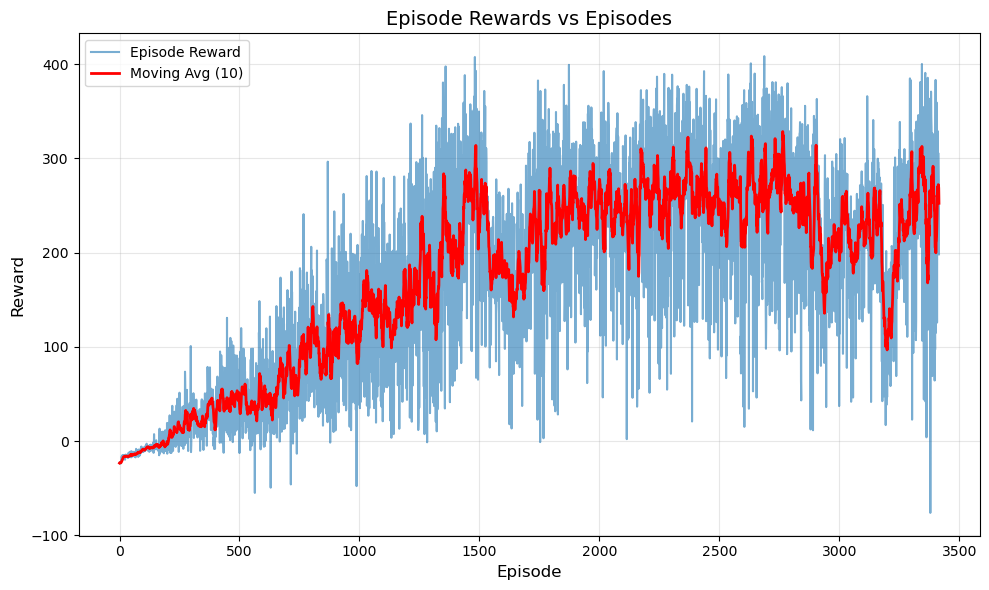

: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, alpha=0.6, label='Episode Reward')

# Add moving average if enough data
if len(episode_rewards) >= 10:
    moving_avg = []
    for i in range(len(episode_rewards)):
        start_idx = max(0, i - 9)
        moving_avg.append(np.mean(episode_rewards[start_idx:i+1]))
    plt.plot(moving_avg, label='Moving Avg (10)', linewidth=2, color='red')

plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.title('Episode Rewards vs Episodes', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('episode_rewards.png', dpi=150)



In [13]:
def evaluate_model(model_path, num_episodes=100, seed=42, render=False, deterministic=True):
    model = ActorCritic().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  
    
    render_mode = 'human' if render else None
    env = gym.make('CarRacing-v3', render_mode=render_mode)
    
    # Set seed for reproducibility
    env.action_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    episode_rewards = []
    episode_lengths = []
    
    
    for episode in tqdm(range(num_episodes)):
        obs, _ = env.reset(seed=seed + episode)  # Different seed per episode
        frame_stack.clear()
        state = get_state(obs)
        
        episode_reward = 0
        episode_length = 0
        done = False
        
        with torch.no_grad():
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                
                mu, std, value = model(state_tensor)
                
                # No exploration during evaluation
                action_raw = mu.squeeze(0).cpu().numpy()
                
                # Clip
                action = action_raw.copy()
                action[0] = np.tanh(action[0])  # steering in [-1, 1]
                action[1] = np.clip(action[1], 0.0, 1.0)  # gas
                action[2] = np.clip(action[2], 0.0, 1.0)  # brake
                
                # Step environment
                next_obs, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                episode_reward += reward
                episode_length += 1
                
                # Update state
                state = get_state(next_obs)
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        
        if (episode + 1) % 10 == 0:
            avg_last_10 = np.mean(episode_rewards[-10:])
            print(f"\nEpisodes {episode-8}-{episode+1}: Avg Reward = {avg_last_10:.2f}")
    
    env.close()
    
    # Calculate statistics
    rewards_array = np.array(episode_rewards)
    
    stats = {
        'mean_reward': np.mean(rewards_array),
        'std_reward': np.std(rewards_array),
        'success_rate': np.mean(rewards_array > 0) * 100,
    }
    
    return stats

In [ ]:
stats = evaluate_model("models/ppo_carracing_best.pt", num_episodes=100, render=False)

 10%|█         | 10/100 [02:36<23:50, 15.89s/it]


Episodes 1-10: Avg Reward = 138.85


 20%|██        | 20/100 [07:04<39:44, 29.81s/it]


Episodes 11-20: Avg Reward = 202.59


 30%|███       | 30/100 [12:39<38:35, 33.08s/it]


Episodes 21-30: Avg Reward = 237.85


 40%|████      | 40/100 [18:00<32:11, 32.19s/it]


Episodes 31-40: Avg Reward = 204.72


 50%|█████     | 50/100 [22:01<20:24, 24.48s/it]


Episodes 41-50: Avg Reward = 156.94


 60%|██████    | 60/100 [25:35<15:11, 22.79s/it]


Episodes 51-60: Avg Reward = 235.06


 70%|███████   | 70/100 [29:24<11:38, 23.29s/it]


Episodes 61-70: Avg Reward = 241.92


 80%|████████  | 80/100 [33:07<07:38, 22.93s/it]


Episodes 71-80: Avg Reward = 183.57


 90%|█████████ | 90/100 [36:52<03:43, 22.34s/it]


Episodes 81-90: Avg Reward = 170.35


100%|██████████| 100/100 [40:59<00:00, 24.59s/it]


Episodes 91-100: Avg Reward = 241.32


In [15]:
stats

{'mean_reward': 201.31753157712558,
 'std_reward': 117.86273466626695,
 'success_rate': 100.0}